🎯 ANÁLISE FINAL ROBUSTA - RESULTADOS CONFIÁVEIS

📊 FILTRANDO OUTLIERS EXTREMOS...
Removidos 5040 registros problemáticos (15.6%)

📈 ESTATÍSTICAS FINAIS (Dados Limpos):
--------------------------------------------------

🏆 RANKING FINAL - DADOS LIMPOS
 1. StackingRegressor    | RMSE:  80.80 | NRMSE:  5.48 | R²:  0.261 | MAPE:  25.25%
 2. Mean                 | RMSE: 114.76 | NRMSE: 10.59 | R²: -0.049 | MAPE:  36.82%
 3. KNNImputer           | RMSE: 114.76 | NRMSE: 10.59 | R²: -0.049 | MAPE:  36.82%
 4. Median               | RMSE: 114.37 | NRMSE: 10.66 | R²: -0.082 | MAPE:  36.47%
 5. LinearInterpolation  | RMSE: 121.97 | NRMSE: 11.24 | R²: -0.419 | MAPE:  35.49%
 6. ForwardFill          | RMSE: 124.65 | NRMSE: 12.32 | R²: -0.791 | MAPE:  34.58%
 7. RollingMean          | RMSE: 124.81 | NRMSE: 11.97 | R²: -0.653 | MAPE:  35.45%
 8. BackwardFill         | RMSE: 123.45 | NRMSE: 12.54 | R²: -0.800 | MAPE:  36.04%

📊 GERANDO GRÁFICOS FINAIS...


<Figure size 1600x1200 with 0 Axes>

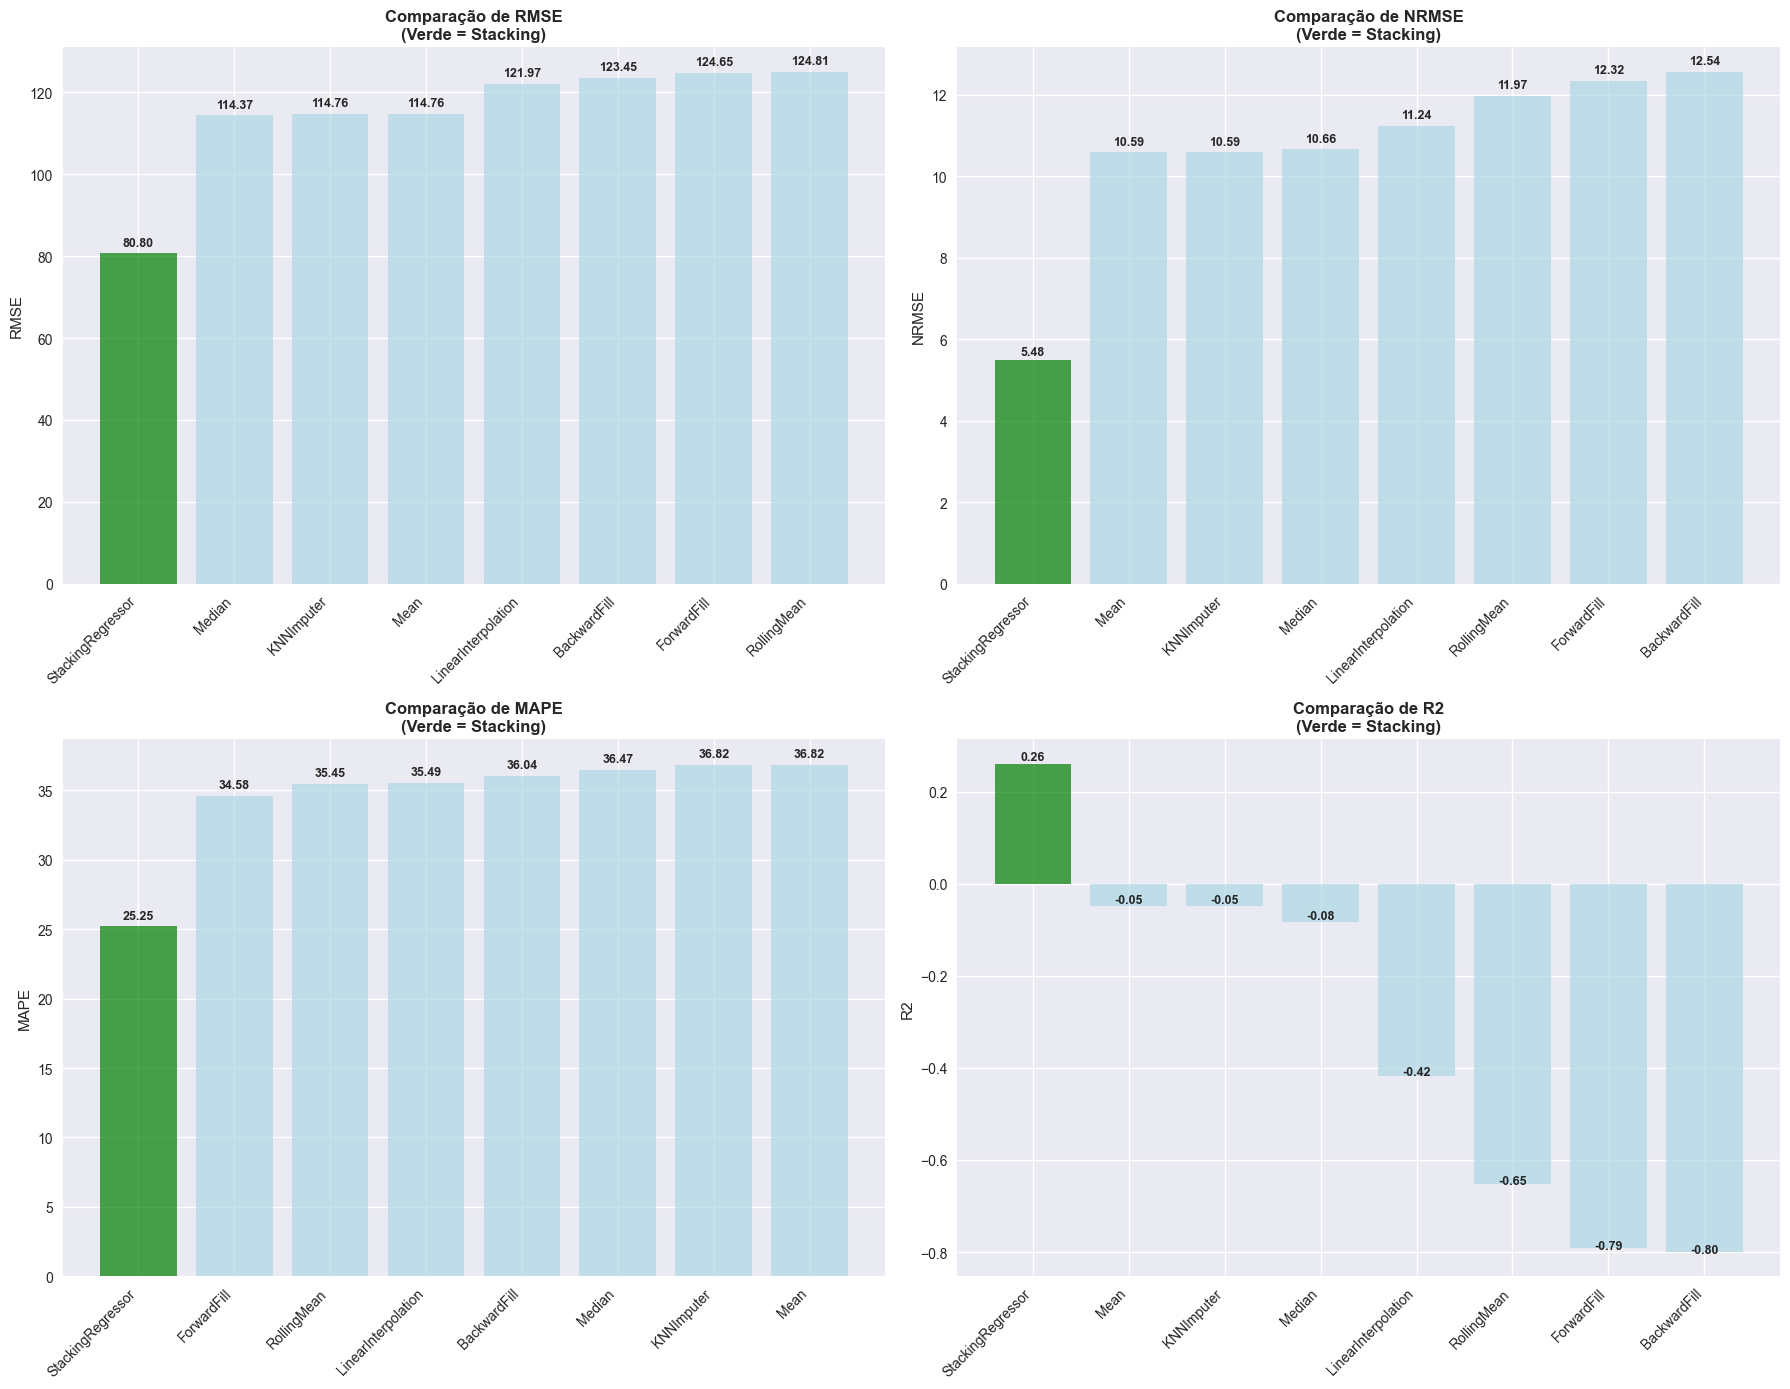


📈 PERFORMANCE POR TAXA DE MISSING (TODOS MÉTODOS)...


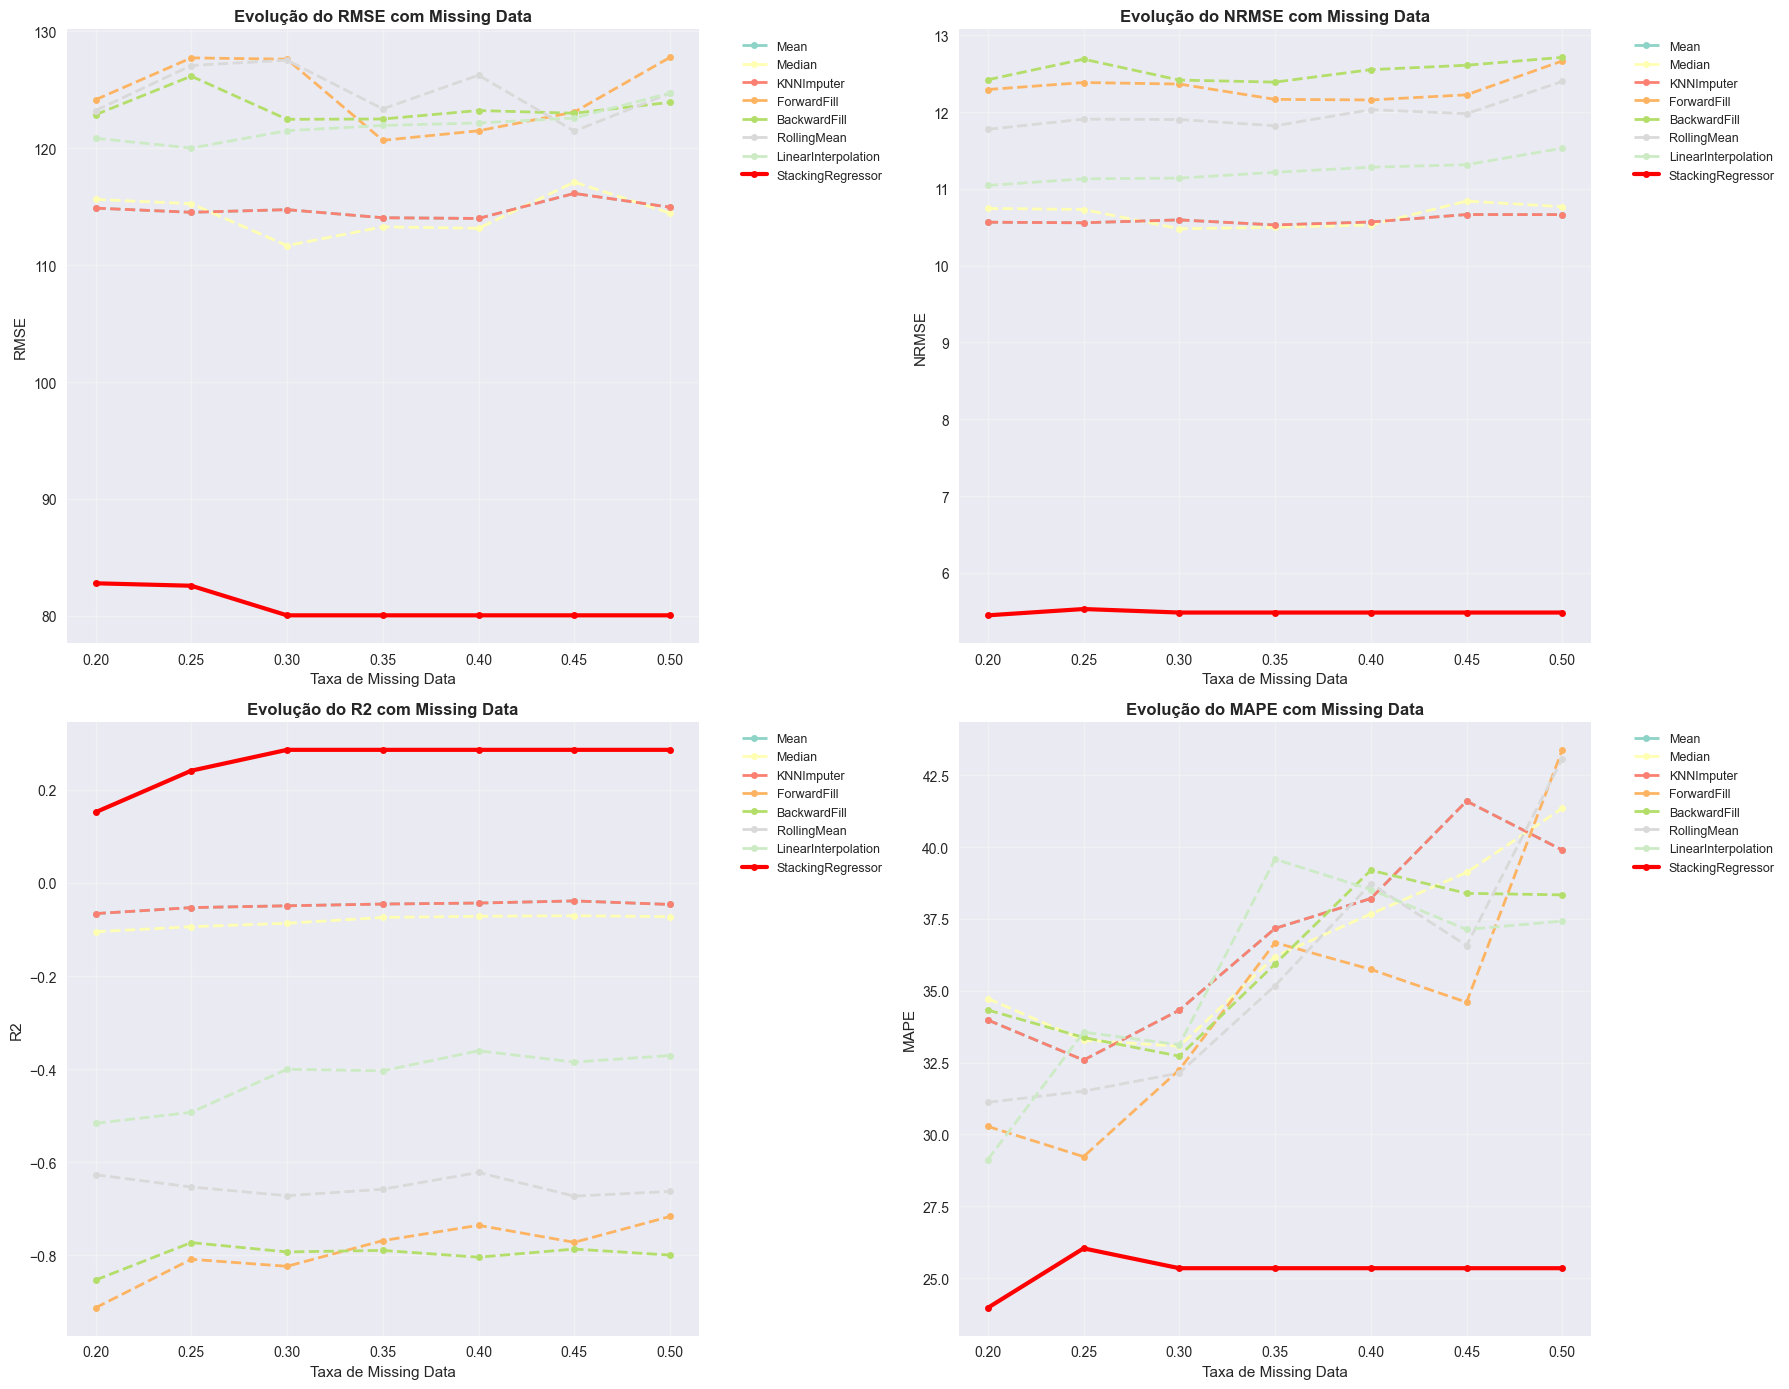


🔥 HEATMAP DE PERFORMANCE...


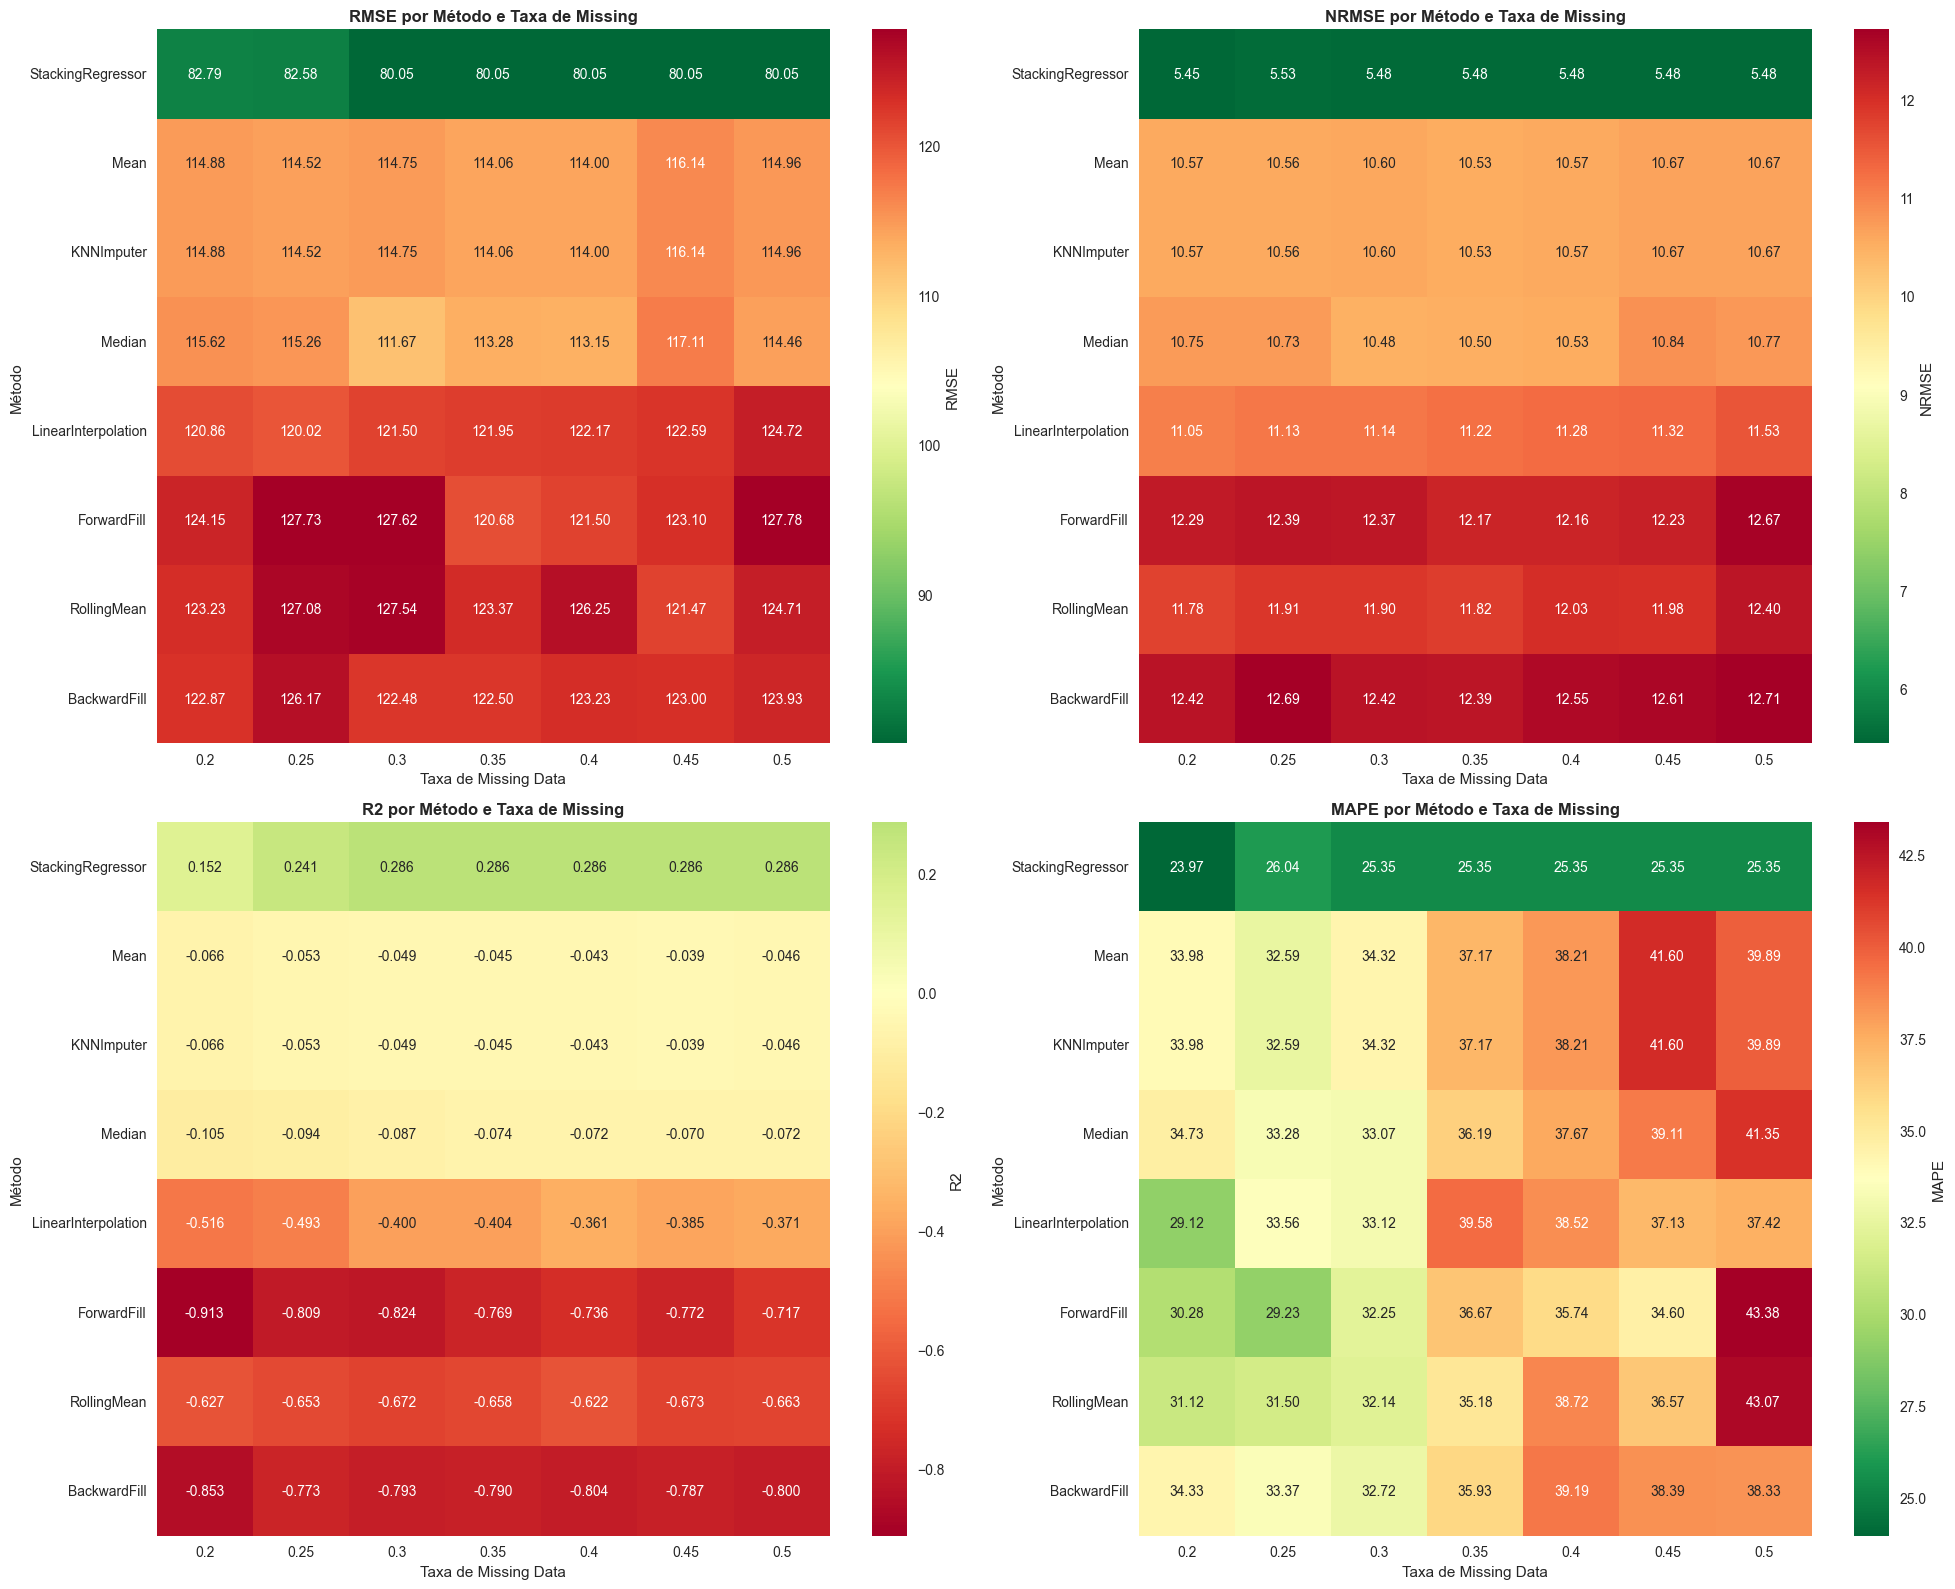


📦 BOXPLOT COMPARATIVO...


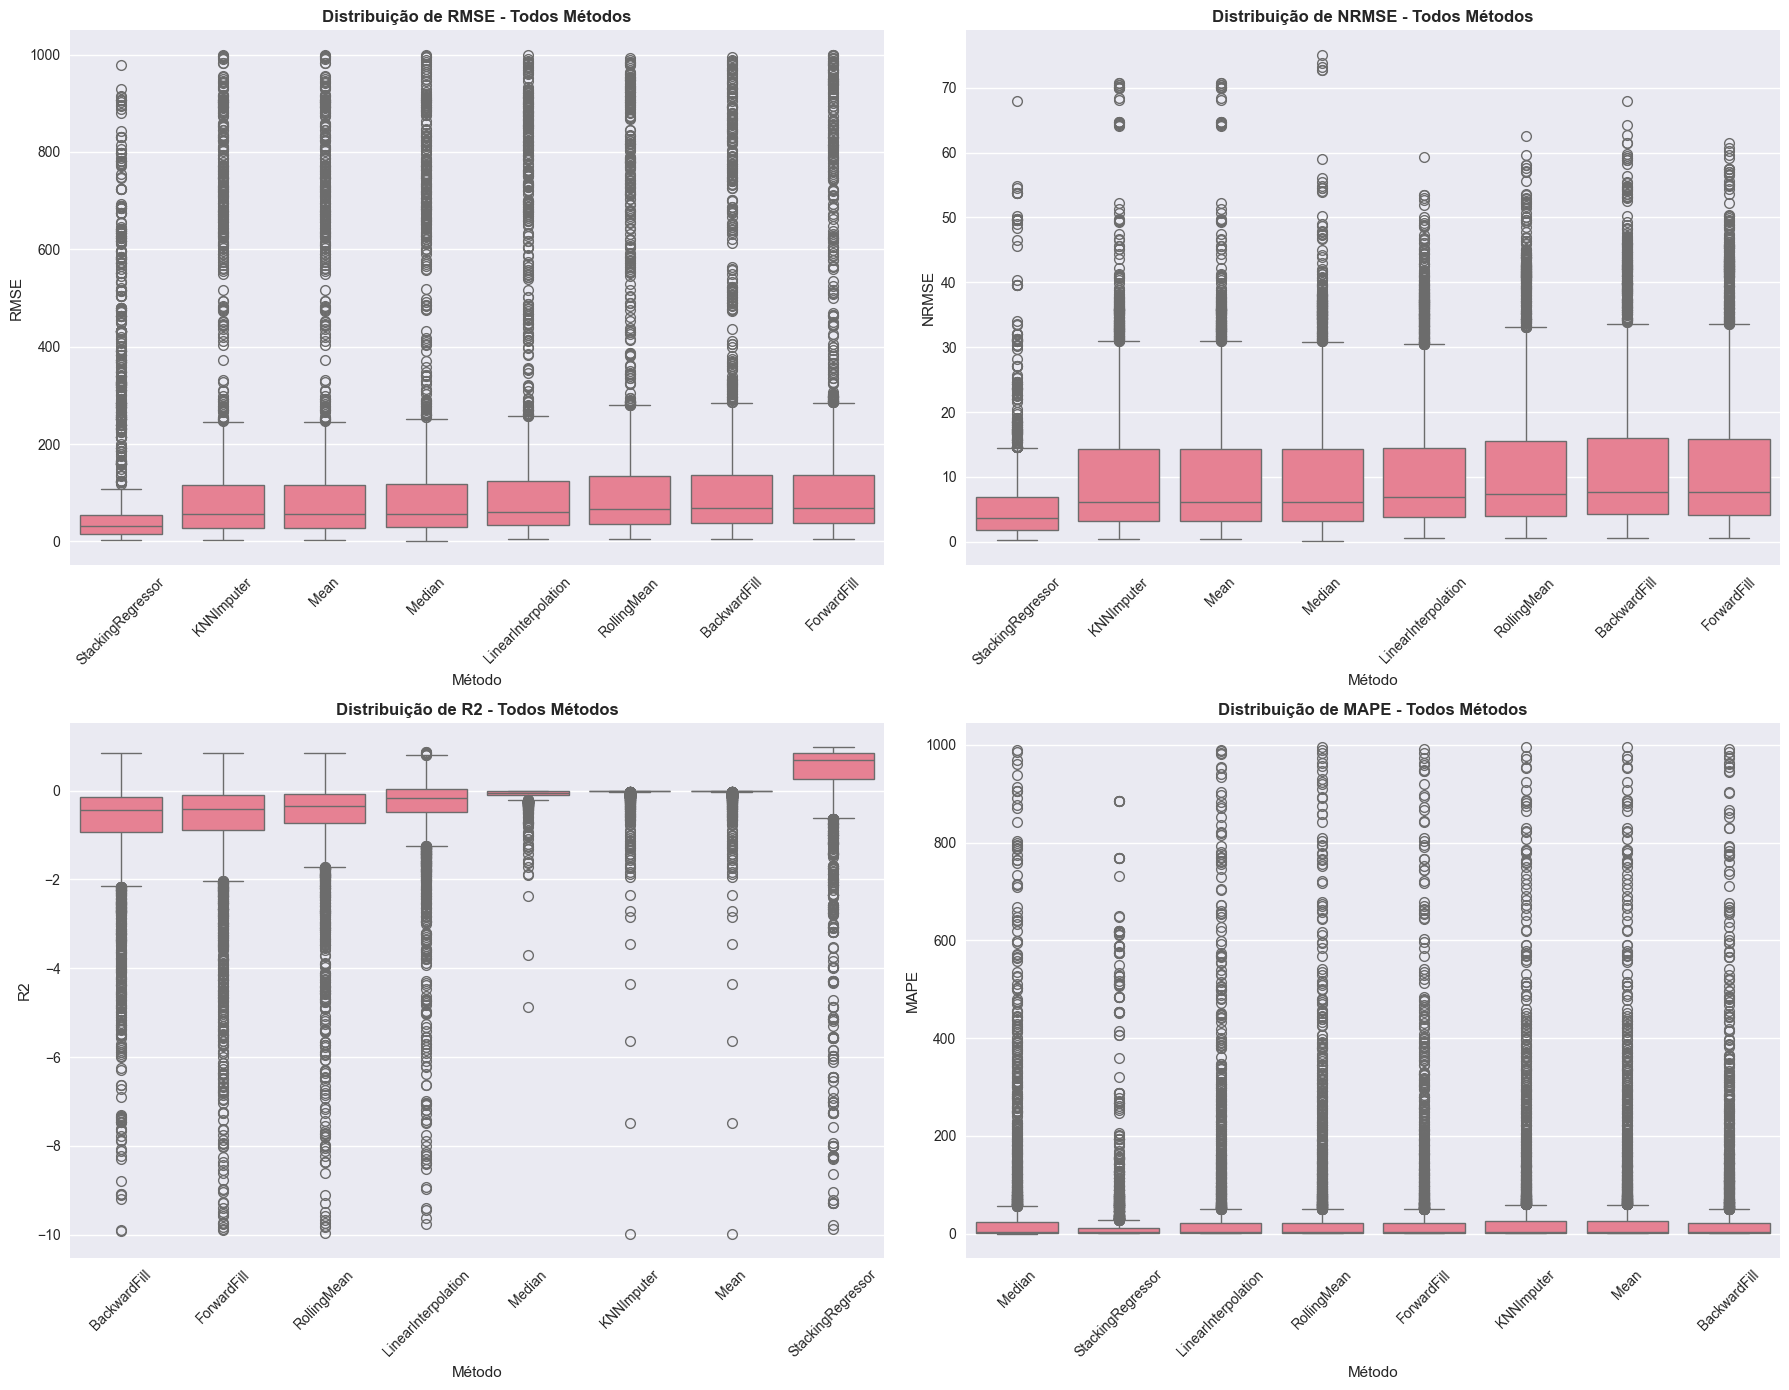


🎓 RESUMO PARA ARTIGO CIENTÍFICO

MELHOR BASELINE: Mean

MELHORIAS DO STACKING vs MELHOR BASELINE:
📍 RMSE:    80.80 vs 114.76 (29.6% melhor)
📍 NRMSE:   5.48 vs 10.59 (48.2% melhor)
📍 R²:      0.261 vs -0.049 (0.309 pontos melhor)
📍 MAPE:    25.25% vs 36.82% (31.4% melhor)

📊 ESTATÍSTICAS GERAIS:
Total de métodos comparados: 8
Total de configurações analisadas: 27272
Taxas de missing analisadas: [np.float64(0.2), np.float64(0.25), np.float64(0.3), np.float64(0.35), np.float64(0.4), np.float64(0.45), np.float64(0.5)]

💾 Dados limpos salvos: 'dados_limpos_analise_final.csv'
📊 Total de registros válidos: 27272


In [63]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

def final_robust_analysis(json_file_path):
    """Análise final robusta - removendo outliers extremos"""
    
    # Carregar e processar dados (mesmo do seu código)
    with open(json_file_path, 'r', encoding='utf-8') as file:
        data = json.load(file)
    
    records = []
    for link, missing_data in data.items():
        for missing_rate, methods in missing_data.items():
            missing_rate_float = float(missing_rate)
            
            for method_name, metrics in methods['baseline'].items():
                records.append({
                    'link': link, 'missing_rate': missing_rate_float,
                    'method_type': 'baseline', 'method': method_name,
                    'rmse': metrics['rmse'], 'nrmse': metrics['nrmse'],
                    'r2': metrics['r2'], 'mape': metrics['mape']
                })
            
            stacking_metrics = methods['stacking']['mean']['StackingRegressor']
            records.append({
                'link': link, 'missing_rate': missing_rate_float,
                'method_type': 'stacking', 'method': 'StackingRegressor',
                'rmse': stacking_metrics['rmse'], 'nrmse': stacking_metrics['nrmse'],
                'r2': stacking_metrics['r2'], 'mape': stacking_metrics['mape']
            })
    
    df = pd.DataFrame(records)
    
    print("🎯 ANÁLISE FINAL ROBUSTA - RESULTADOS CONFIÁVEIS")
    print("=" * 80)
    
    # REMOVER OUTLIERS EXTREMOS (baseado na sua análise)
    print("\n📊 FILTRANDO OUTLIERS EXTREMOS...")
    
    # Critérios mais conservadores para outliers
    df_clean = df.copy()
    
    # Remover casos com MAPE extremamente alto (indicando problemas numéricos)
    mape_threshold = 1000  # MAPE acima de 1000% é considerado outlier
    initial_count = len(df_clean)
    df_clean = df_clean[df_clean['mape'] <= mape_threshold]
    
    # Remover R² extremamente negativo
    r2_threshold = -10
    df_clean = df_clean[df_clean['r2'] >= r2_threshold]
    
    # Remover RMSE extremamente alto
    rmse_threshold = 1000
    df_clean = df_clean[df_clean['rmse'] <= rmse_threshold]
    
    removed_count = initial_count - len(df_clean)
    print(f"Removidos {removed_count} registros problemáticos ({removed_count/initial_count*100:.1f}%)")
    
    # ESTATÍSTICAS FINAIS CONFIÁVEIS
    print("\n📈 ESTATÍSTICAS FINAIS (Dados Limpos):")
    print("-" * 50)
    
    metrics = ['rmse', 'nrmse', 'r2', 'mape']
    summary_data = []
    
    for method in df_clean['method'].unique():
        method_data = df_clean[df_clean['method'] == method]
        row = {'method': method, 'count': len(method_data)}
        
        for metric in metrics:
            values = method_data[metric]
            row[f'{metric}_mean'] = values.mean()
            row[f'{metric}_std'] = values.std()
            row[f'{metric}_median'] = values.median()
        
        summary_data.append(row)
    
    summary_df = pd.DataFrame(summary_data)
    
    # Calcular ranking por métrica
    for metric in metrics:
        if metric == 'r2':
            # Para R², maior é melhor
            summary_df[f'{metric}_rank'] = summary_df[f'{metric}_mean'].rank(ascending=False)
        else:
            # Para outras métricas, menor é melhor
            summary_df[f'{metric}_rank'] = summary_df[f'{metric}_mean'].rank(ascending=True)
    
    # Ranking geral (média dos ranks)
    rank_columns = [f'{metric}_rank' for metric in metrics]
    summary_df['overall_rank'] = summary_df[rank_columns].mean(axis=1)
    summary_df = summary_df.sort_values('overall_rank')
    
    print("\n" + "=" * 80)
    print("🏆 RANKING FINAL - DADOS LIMPOS")
    print("=" * 80)
    
    for i, (_, row) in enumerate(summary_df.iterrows(), 1):
        print(f"{i:2d}. {row['method']:20s} | "
              f"RMSE: {row['rmse_mean']:6.2f} | "
              f"NRMSE: {row['nrmse_mean']:5.2f} | "
              f"R²: {row['r2_mean']:6.3f} | "
              f"MAPE: {row['mape_mean']:6.2f}%")
    
    # GRÁFICOS FINAIS
    print("\n📊 GERANDO GRÁFICOS FINAIS...")
    
    # 1. Comparação direta Stacking vs TODAS as Baselines
    plt.figure(figsize=(16, 12))
    
    # Todas as baselines + stacking
    all_methods = df_clean['method'].unique()
    
    comparison_data = []
    
    for method in all_methods:
        method_data = df_clean[df_clean['method'] == method]
        comparison_data.append({
            'method': method,
            'rmse': method_data['rmse'].mean(),
            'nrmse': method_data['nrmse'].mean(),
            'r2': method_data['r2'].mean(),
            'mape': method_data['mape'].mean()
        })
    
    comp_df = pd.DataFrame(comparison_data)
    
    # Plot com TODOS os métodos
    metrics_for_plot = ['rmse', 'nrmse', 'mape']
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))
    
    for idx, metric in enumerate(metrics_for_plot + ['r2']):
        if metric == 'r2':
            # Para R², maior é melhor - ordenar descendente
            sorted_df = comp_df.sort_values(metric, ascending=False)
            colors = ['green' if x == 'StackingRegressor' else 'lightblue' for x in sorted_df['method']]
        else:
            # Para outras métricas, menor é melhor - ordenar ascendente
            sorted_df = comp_df.sort_values(metric, ascending=True)
            colors = ['green' if x == 'StackingRegressor' else 'lightblue' for x in sorted_df['method']]
        
        bars = axes[idx//2, idx%2].bar(range(len(sorted_df)), sorted_df[metric], color=colors, alpha=0.7)
        axes[idx//2, idx%2].set_title(f'Comparação de {metric.upper()}\n(Verde = Stacking)', fontweight='bold', fontsize=12)
        axes[idx//2, idx%2].set_ylabel(metric.upper(), fontsize=11)
        axes[idx//2, idx%2].set_xticks(range(len(sorted_df)))
        axes[idx//2, idx%2].set_xticklabels(sorted_df['method'], rotation=45, ha='right', fontsize=10)
        
        # Adicionar valores nas barras
        for bar, value in zip(bars, sorted_df[metric]):
            height = bar.get_height()
            axes[idx//2, idx%2].text(bar.get_x() + bar.get_width()/2, height + height*0.01,
                          f'{value:.2f}', ha='center', va='bottom', fontweight='bold', fontsize=9)
    
    plt.tight_layout()
    plt.savefig('comparacao_final_todas_baselines.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 2. Performance por taxa de missing (TODOS os métodos)
    print("\n📈 PERFORMANCE POR TAXA DE MISSING (TODOS MÉTODOS)...")
    
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))
    
    # Cores distintas para cada método
    colors = plt.cm.Set3(np.linspace(0, 1, len(all_methods)))
    color_map = {method: color for method, color in zip(all_methods, colors)}
    
    for idx, metric in enumerate(metrics):
        ax = axes[idx//2, idx%2]
        
        for method in all_methods:
            method_data = df_clean[df_clean['method'] == method]
            performance_by_missing = method_data.groupby('missing_rate')[metric].mean().sort_index()
            
            # Usar cor vermelha para Stacking, outras cores para baselines
            color = 'red' if method == 'StackingRegressor' else color_map[method]
            linewidth = 3 if method == 'StackingRegressor' else 2
            linestyle = '-' if method == 'StackingRegressor' else '--'
            
            ax.plot(performance_by_missing.index, performance_by_missing.values, 
                   marker='o', linewidth=linewidth, label=method, 
                   markersize=5, color=color, linestyle=linestyle)
        
        ax.set_title(f'Evolução do {metric.upper()} com Missing Data', fontweight='bold', fontsize=12)
        ax.set_xlabel('Taxa de Missing Data', fontsize=11)
        ax.set_ylabel(metric.upper(), fontsize=11)
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('evolucao_missing_todos_metodos.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 3. Heatmap de performance (todos métodos x todas taxas de missing)
    print("\n🔥 HEATMAP DE PERFORMANCE...")
    
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    
    for idx, metric in enumerate(metrics):
        ax = axes[idx//2, idx%2]
        
        # Criar pivot table
        pivot_data = df_clean.pivot_table(values=metric, index='method', columns='missing_rate', aggfunc='mean')
        
        # Ordenar métodos pelo ranking geral
        method_order = summary_df['method'].values
        pivot_data = pivot_data.reindex(method_order)
        
        # Para R², valores mais altos são melhores
        if metric == 'r2':
            sns.heatmap(pivot_data, annot=True, fmt='.3f', cmap='RdYlGn', center=0, ax=ax,
                       cbar_kws={'label': metric.upper()})
        else:
            sns.heatmap(pivot_data, annot=True, fmt='.2f', cmap='RdYlGn_r', ax=ax,
                       cbar_kws={'label': metric.upper()})
        
        ax.set_title(f'{metric.upper()} por Método e Taxa de Missing', fontweight='bold', fontsize=12)
        ax.set_xlabel('Taxa de Missing Data', fontsize=11)
        ax.set_ylabel('Método', fontsize=11)
    
    plt.tight_layout()
    plt.savefig('heatmap_todos_metodos.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 4. Boxplot comparativo de todas as métricas
    print("\n📦 BOXPLOT COMPARATIVO...")
    
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))
    
    for idx, metric in enumerate(metrics):
        ax = axes[idx//2, idx%2]
        
        # Ordenar métodos pela mediana
        method_order = df_clean.groupby('method')[metric].median().sort_values().index
        
        sns.boxplot(data=df_clean, x='method', y=metric, ax=ax, order=method_order)
        ax.set_title(f'Distribuição de {metric.upper()} - Todos Métodos', fontweight='bold', fontsize=12)
        ax.set_xlabel('Método', fontsize=11)
        ax.set_ylabel(metric.upper(), fontsize=11)
        ax.tick_params(axis='x', rotation=45)
        
        # Destacar Stacking
        for i, artist in enumerate(ax.artists):
            if method_order[i] == 'StackingRegressor':
                artist.set_facecolor('lightgreen')
                artist.set_edgecolor('darkgreen')
                artist.set_linewidth(2)
    
    plt.tight_layout()
    plt.savefig('boxplot_todos_metodos.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # RESUMO FINAL PARA ARTIGO
    print("\n" + "=" * 80)
    print("🎓 RESUMO PARA ARTIGO CIENTÍFICO")
    print("=" * 80)
    
    stacking_data = df_clean[df_clean['method'] == 'StackingRegressor']
    best_baseline_data = df_clean[df_clean['method'] == summary_df.iloc[1]['method']]  # Segundo colocado
    
    print(f"\nMELHOR BASELINE: {summary_df.iloc[1]['method']}")
    
    print(f"\nMELHORIAS DO STACKING vs MELHOR BASELINE:")
    print(f"📍 RMSE:    {stacking_data['rmse'].mean():.2f} vs {best_baseline_data['rmse'].mean():.2f} "
          f"({(1 - stacking_data['rmse'].mean()/best_baseline_data['rmse'].mean())*100:.1f}% melhor)")
    print(f"📍 NRMSE:   {stacking_data['nrmse'].mean():.2f} vs {best_baseline_data['nrmse'].mean():.2f} "
          f"({(1 - stacking_data['nrmse'].mean()/best_baseline_data['nrmse'].mean())*100:.1f}% melhor)")
    print(f"📍 R²:      {stacking_data['r2'].mean():.3f} vs {best_baseline_data['r2'].mean():.3f} "
          f"({(stacking_data['r2'].mean() - best_baseline_data['r2'].mean()):.3f} pontos melhor)")
    print(f"📍 MAPE:    {stacking_data['mape'].mean():.2f}% vs {best_baseline_data['mape'].mean():.2f}% "
          f"({(1 - stacking_data['mape'].mean()/best_baseline_data['mape'].mean())*100:.1f}% melhor)")
    
    print(f"\n📊 ESTATÍSTICAS GERAIS:")
    print(f"Total de métodos comparados: {len(all_methods)}")
    print(f"Total de configurações analisadas: {len(df_clean)}")
    print(f"Taxas de missing analisadas: {sorted(df_clean['missing_rate'].unique())}")
    
    # Salvar dados limpos
    df_clean.to_csv('dados_limpos_analise_final.csv', index=False)
    print(f"\n💾 Dados limpos salvos: 'dados_limpos_analise_final.csv'")
    print(f"📊 Total de registros válidos: {len(df_clean)}")

# Executar análise final
json_file_path = "../../results/metrics_summary_complete.json"
final_robust_analysis(json_file_path)

🎯 ANÁLISE FINAL ROBUSTA - RESULTADOS CONFIÁVEIS

📊 FILTRANDO OUTLIERS EXTREMOS...
Removidos 5040 registros problemáticos (15.6%)

📈 ESTATÍSTICAS FINAIS COMPLETAS (Dados Limpos):
------------------------------------------------------------

🏆 RANKING FINAL - DADOS LIMPOS
 1. StackingRegressor    | RMSE:  80.80 | NRMSE:  5.48 | R²:  0.261 | MAPE:  25.25%
 2. Mean                 | RMSE: 114.76 | NRMSE: 10.59 | R²: -0.049 | MAPE:  36.82%
 3. KNNImputer           | RMSE: 114.76 | NRMSE: 10.59 | R²: -0.049 | MAPE:  36.82%
 4. Median               | RMSE: 114.37 | NRMSE: 10.66 | R²: -0.082 | MAPE:  36.47%
 5. LinearInterpolation  | RMSE: 121.97 | NRMSE: 11.24 | R²: -0.419 | MAPE:  35.49%
 6. ForwardFill          | RMSE: 124.65 | NRMSE: 12.32 | R²: -0.791 | MAPE:  34.58%
 7. RollingMean          | RMSE: 124.81 | NRMSE: 11.97 | R²: -0.653 | MAPE:  35.45%
 8. BackwardFill         | RMSE: 123.45 | NRMSE: 12.54 | R²: -0.800 | MAPE:  36.04%

📊 ESTATÍSTICAS DETALHADAS POR MÉTODO

📈 StackingRegresso

<Figure size 1600x1200 with 0 Axes>

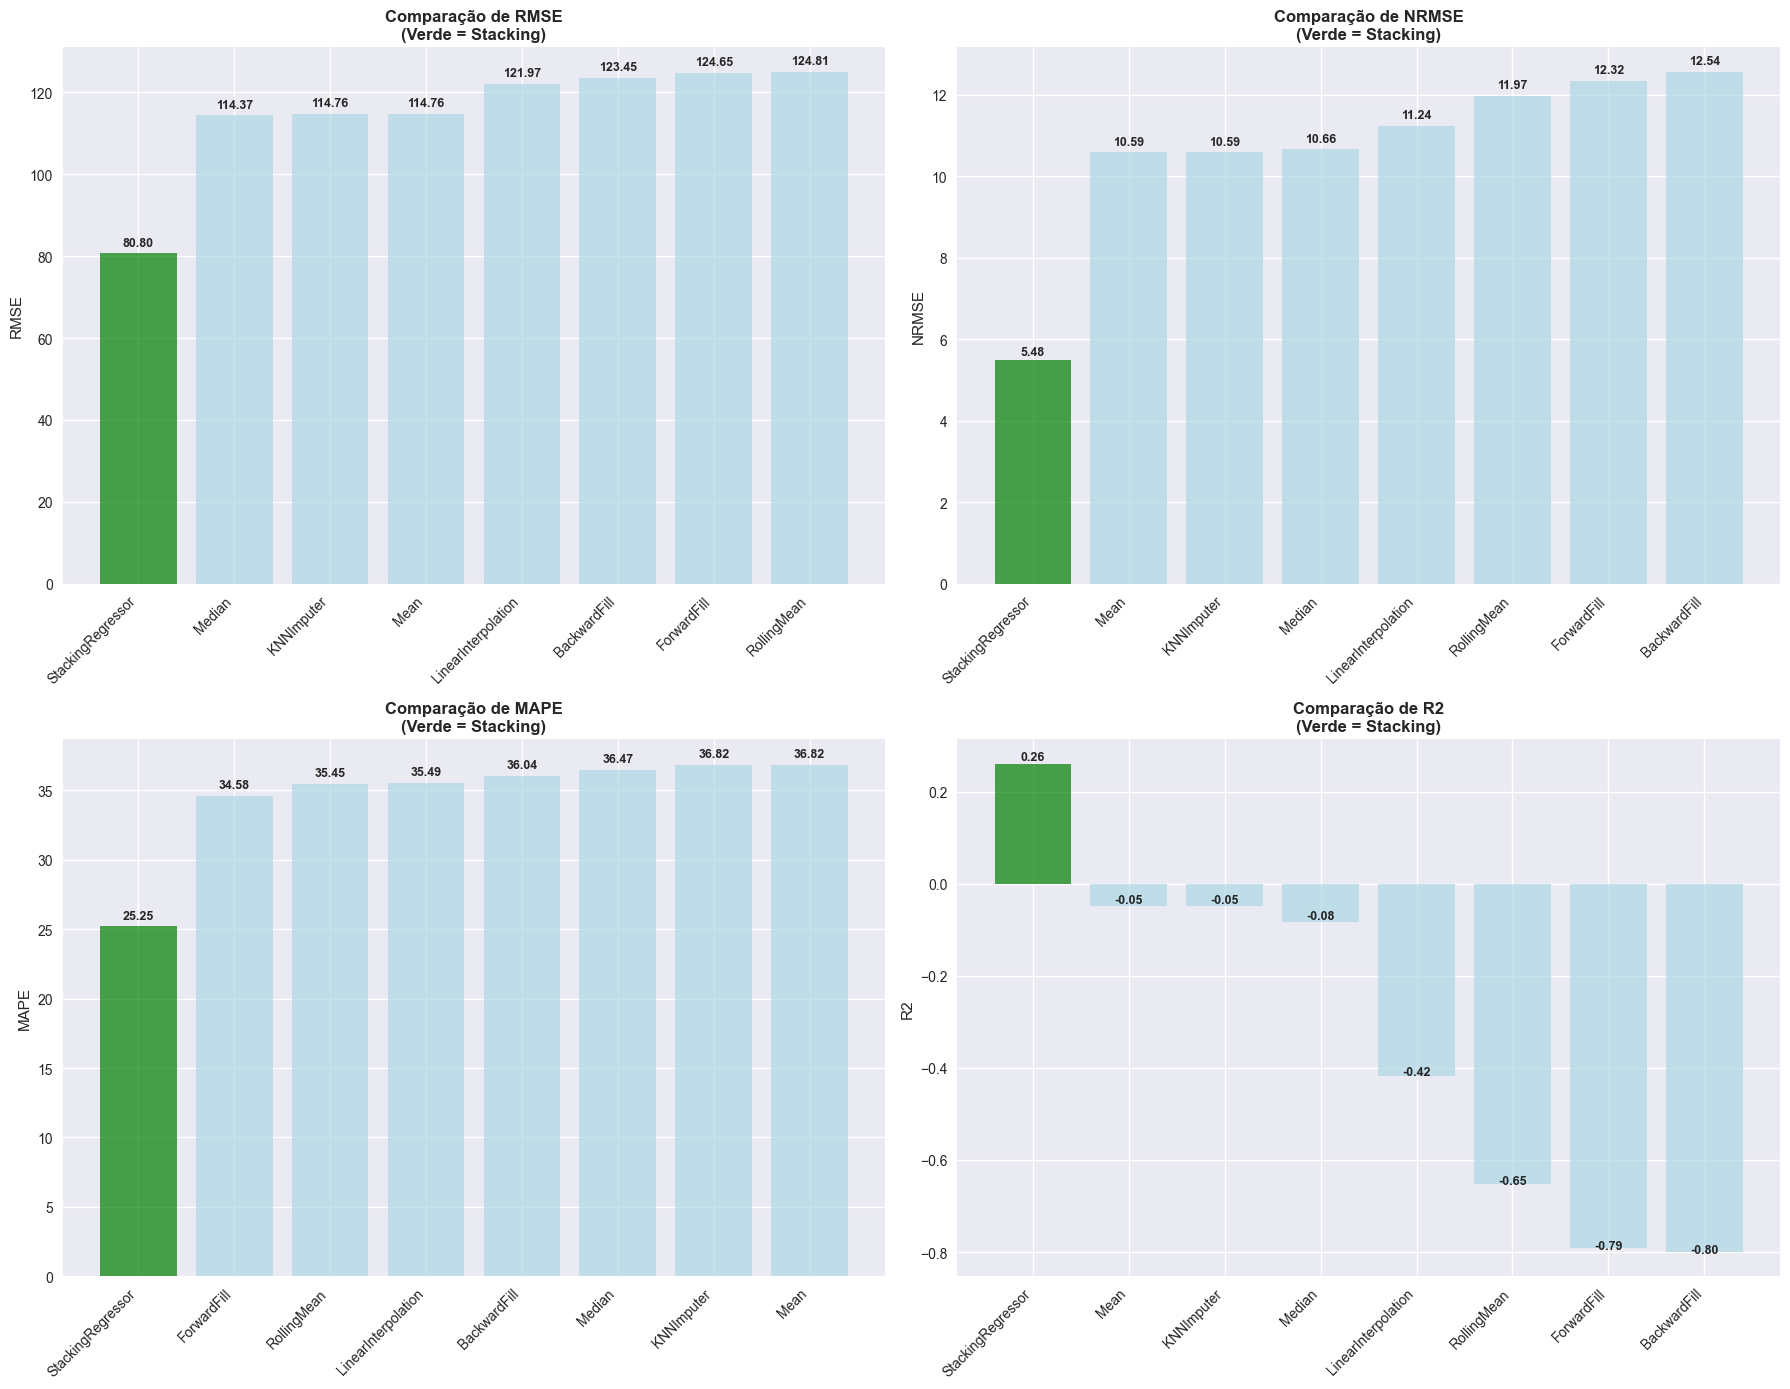


📈 PERFORMANCE POR TAXA DE MISSING (TODOS MÉTODOS)...


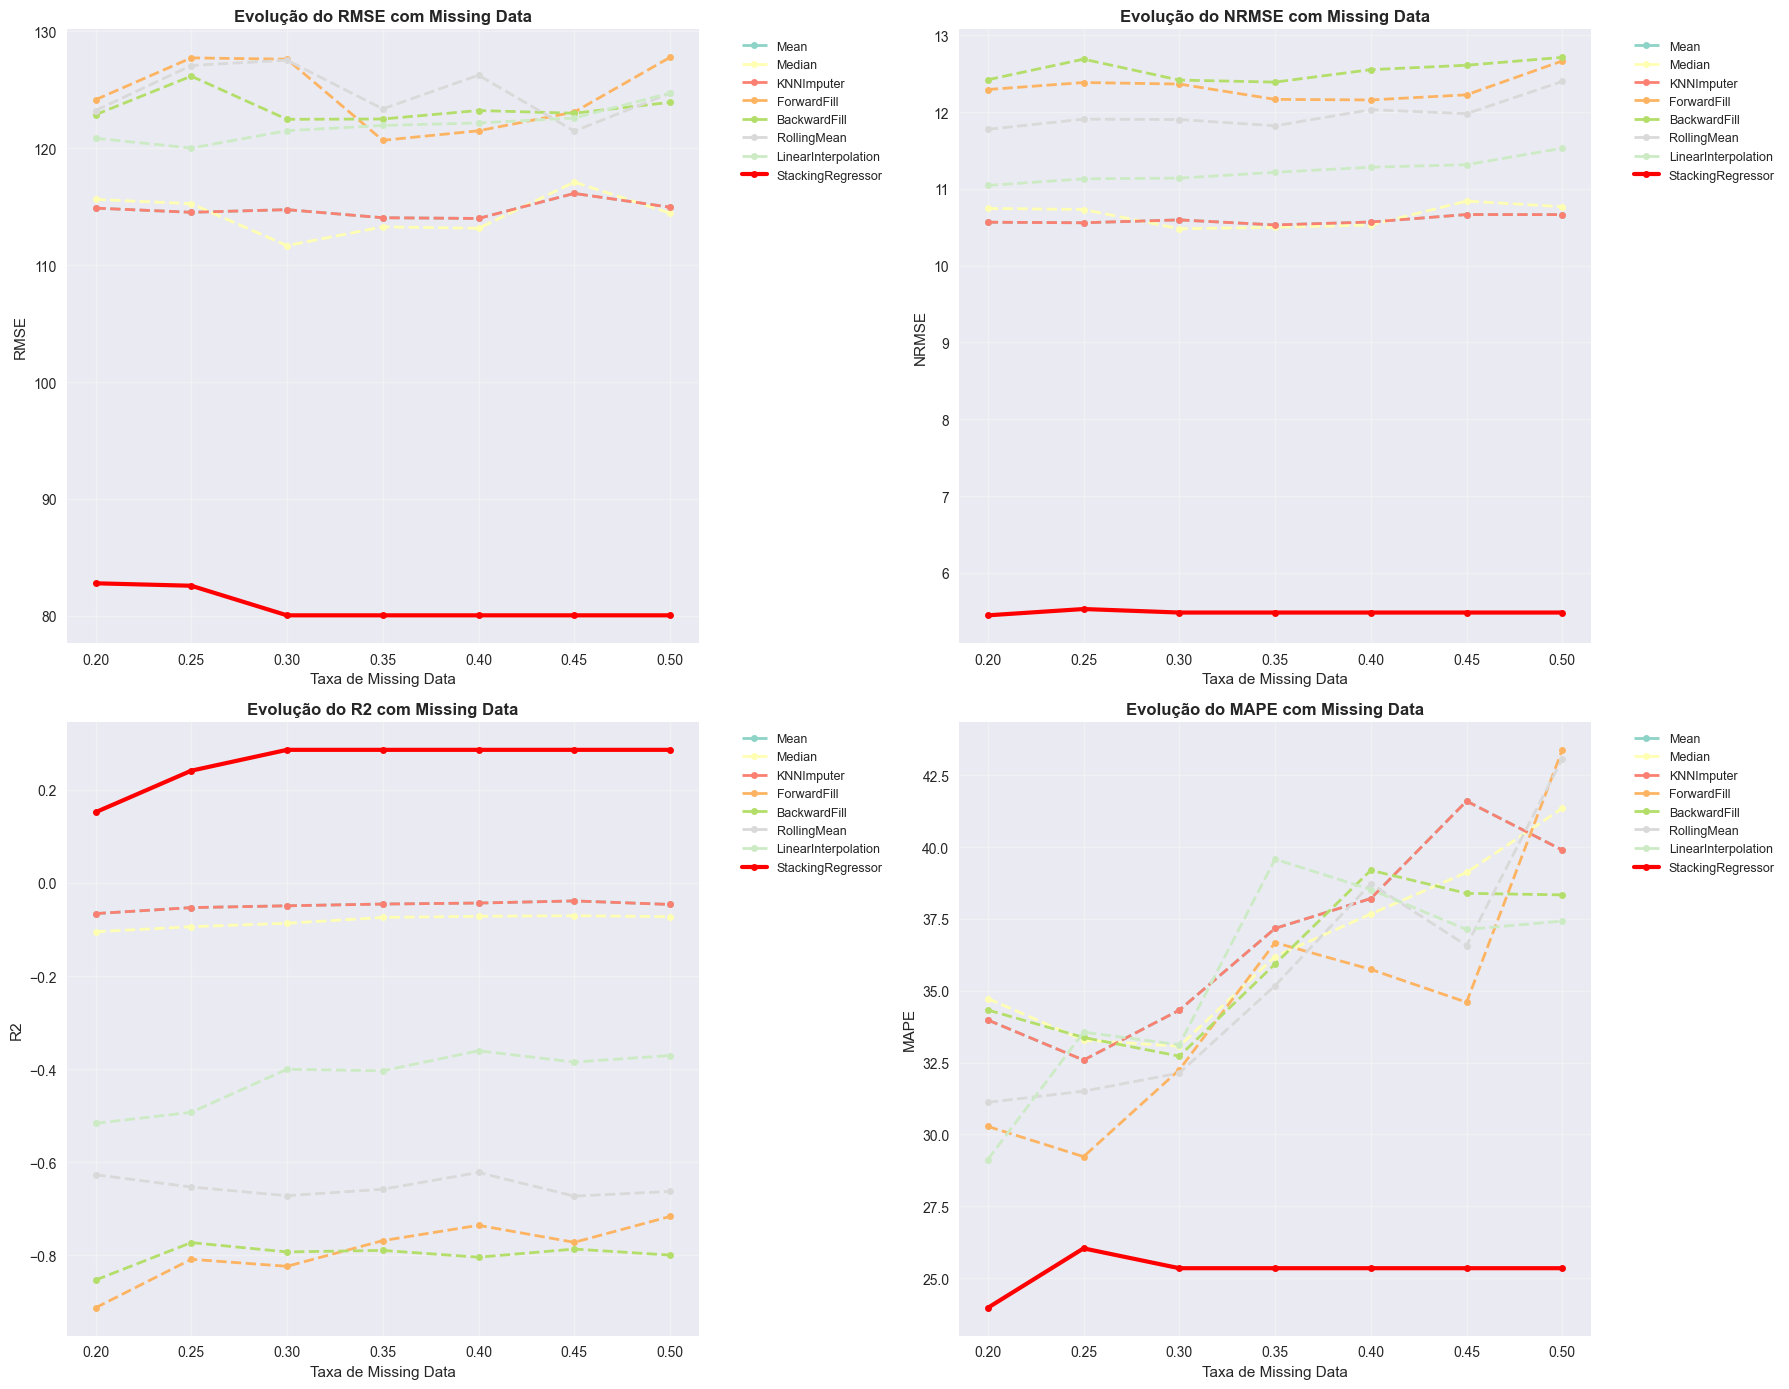


📦 BOXPLOT COMPARATIVO...


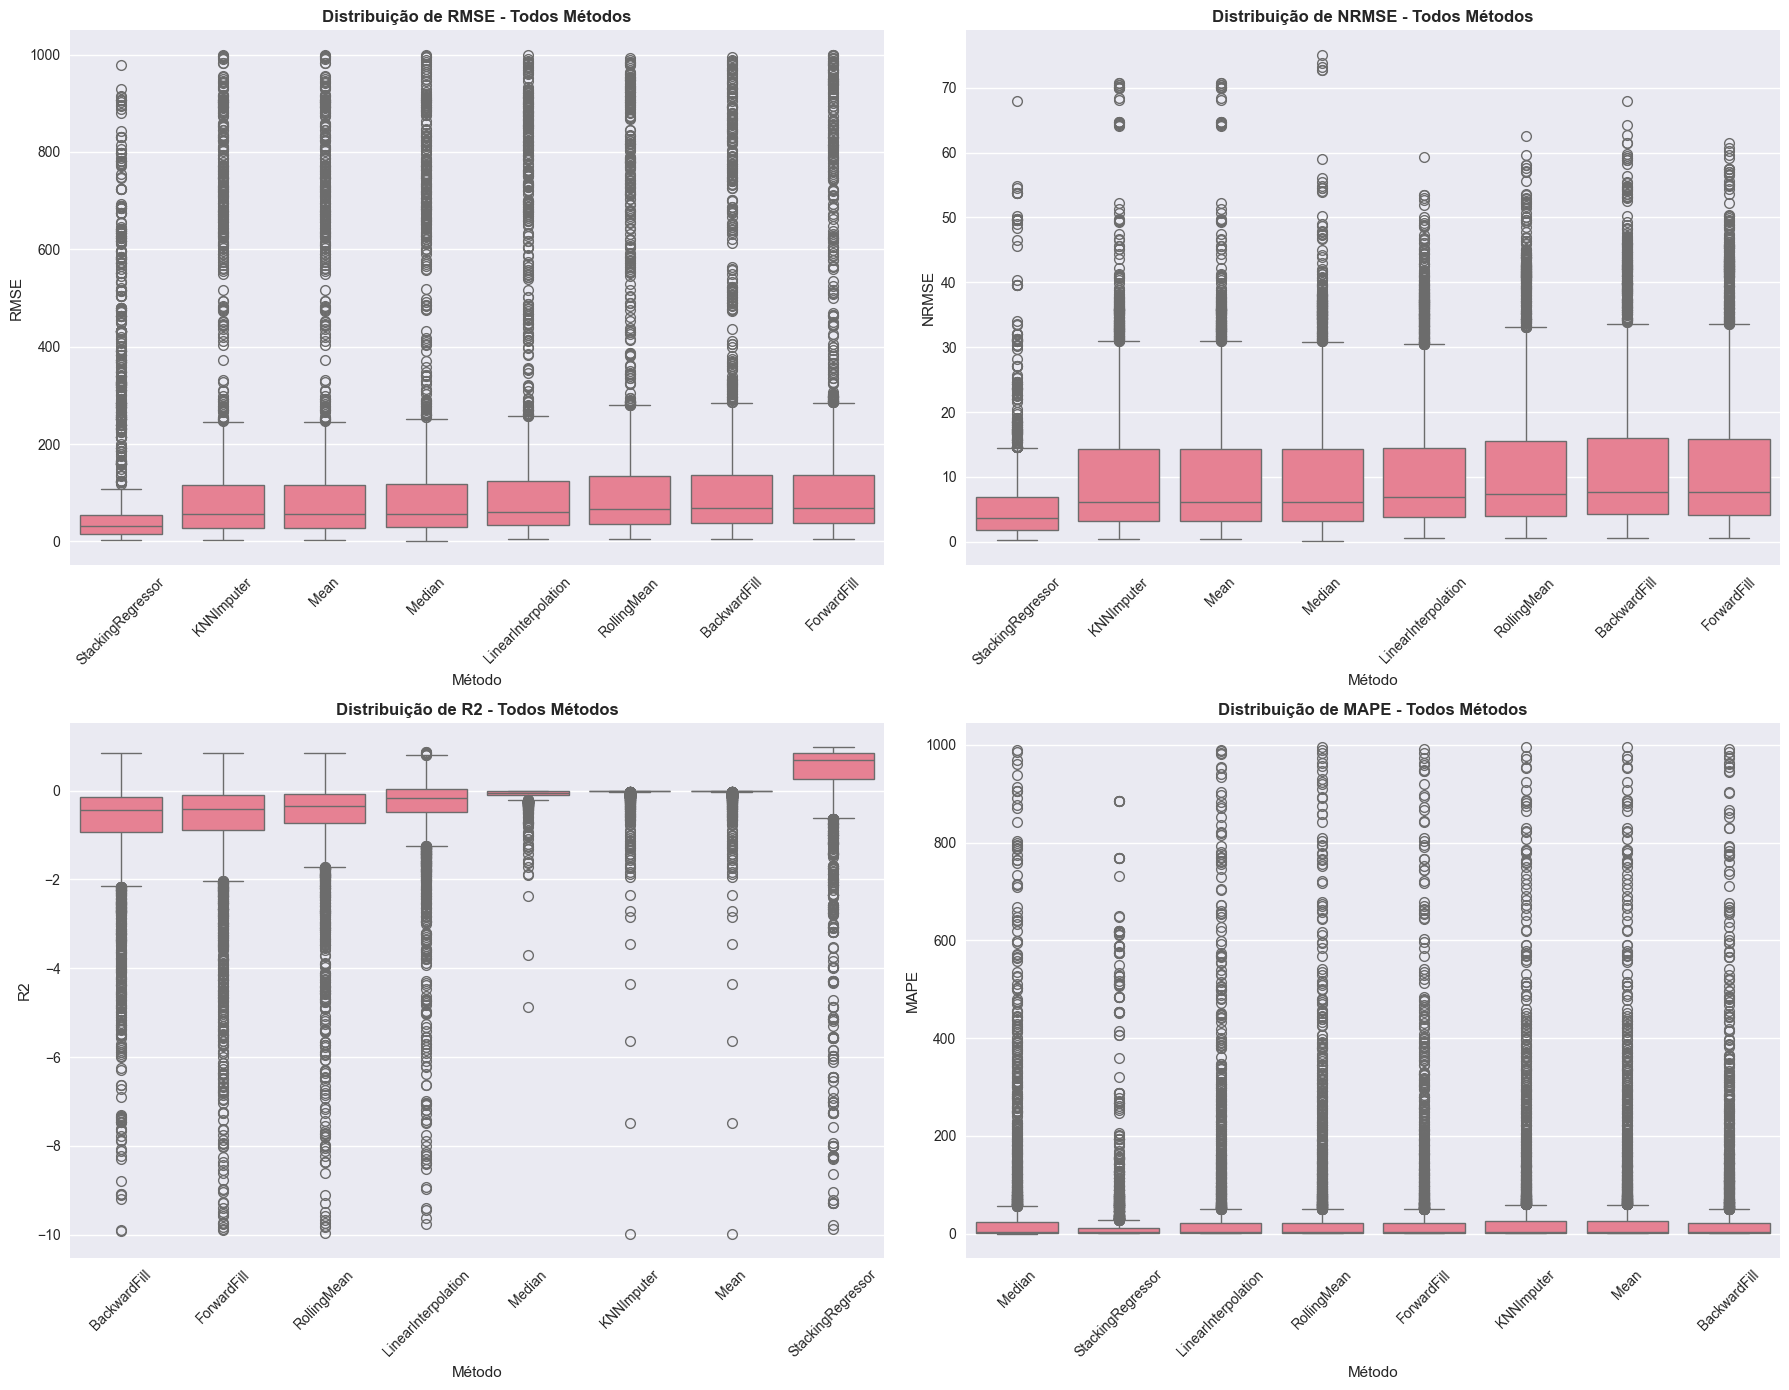


🎓 RESUMO PARA ARTIGO CIENTÍFICO

MELHOR BASELINE: Mean

📊 COMPARAÇÃO ESTATÍSTICA DETALHADA:

📍 RMSE:
   Stacking:    80.80 ± 150.39
   Baseline:    114.76 ± 174.65
   Melhoria:    29.6%

📍 NRMSE:
   Stacking:    5.48 ± 6.37
   Baseline:    10.59 ± 10.77
   Melhoria:    48.2%

📍 R²:
   Stacking:    0.261 ± 1.329
   Baseline:    -0.049 ± 0.300
   Melhoria:    0.309 pontos

📍 MAPE:
   Stacking:    25.25% ± 86.88%
   Baseline:    36.82% ± 105.33%
   Melhoria:    31.4%

📈 ESTATÍSTICAS GERAIS:
   Total de métodos comparados: 8
   Total de configurações analisadas: 27272
   Taxas de missing analisadas: [np.float64(0.2), np.float64(0.25), np.float64(0.3), np.float64(0.35), np.float64(0.4), np.float64(0.45), np.float64(0.5)]
   Outliers removidos: 5040 (15.6%)

💾 Arquivos salvos:
   - 'dados_limpos_analise_final.csv'
   - 'estatisticas_detalhadas.csv'
📊 Total de registros válidos: 27272


In [64]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

def final_robust_analysis(json_file_path):
    """Análise final robusta - removendo outliers extremos"""
    
    # Carregar e processar dados (mesmo do seu código)
    with open(json_file_path, 'r', encoding='utf-8') as file:
        data = json.load(file)
    
    records = []
    for link, missing_data in data.items():
        for missing_rate, methods in missing_data.items():
            missing_rate_float = float(missing_rate)
            
            for method_name, metrics in methods['baseline'].items():
                records.append({
                    'link': link, 'missing_rate': missing_rate_float,
                    'method_type': 'baseline', 'method': method_name,
                    'rmse': metrics['rmse'], 'nrmse': metrics['nrmse'],
                    'r2': metrics['r2'], 'mape': metrics['mape']
                })
            
            stacking_metrics = methods['stacking']['mean']['StackingRegressor']
            records.append({
                'link': link, 'missing_rate': missing_rate_float,
                'method_type': 'stacking', 'method': 'StackingRegressor',
                'rmse': stacking_metrics['rmse'], 'nrmse': stacking_metrics['nrmse'],
                'r2': stacking_metrics['r2'], 'mape': stacking_metrics['mape']
            })
    
    df = pd.DataFrame(records)
    
    print("🎯 ANÁLISE FINAL ROBUSTA - RESULTADOS CONFIÁVEIS")
    print("=" * 80)
    
    # REMOVER OUTLIERS EXTREMOS (baseado na sua análise)
    print("\n📊 FILTRANDO OUTLIERS EXTREMOS...")
    
    # Critérios mais conservadores para outliers
    df_clean = df.copy()
    
    # Remover casos com MAPE extremamente alto (indicando problemas numéricos)
    mape_threshold = 1000  # MAPE acima de 1000% é considerado outlier
    initial_count = len(df_clean)
    df_clean = df_clean[df_clean['mape'] <= mape_threshold]
    
    # Remover R² extremamente negativo
    r2_threshold = -10
    df_clean = df_clean[df_clean['r2'] >= r2_threshold]
    
    # Remover RMSE extremamente alto
    rmse_threshold = 1000
    df_clean = df_clean[df_clean['rmse'] <= rmse_threshold]
    
    removed_count = initial_count - len(df_clean)
    print(f"Removidos {removed_count} registros problemáticos ({removed_count/initial_count*100:.1f}%)")
    
    # ESTATÍSTICAS FINAIS COMPLETAS
    print("\n📈 ESTATÍSTICAS FINAIS COMPLETAS (Dados Limpos):")
    print("-" * 60)
    
    metrics = ['rmse', 'nrmse', 'r2', 'mape']
    summary_data = []
    
    for method in df_clean['method'].unique():
        method_data = df_clean[df_clean['method'] == method]
        row = {'method': method, 'count': len(method_data)}
        
        for metric in metrics:
            values = method_data[metric]
            row[f'{metric}_mean'] = values.mean()
            row[f'{metric}_std'] = values.std()
            row[f'{metric}_median'] = values.median()
            row[f'{metric}_min'] = values.min()
            row[f'{metric}_max'] = values.max()
            row[f'{metric}_q1'] = values.quantile(0.25)
            row[f'{metric}_q3'] = values.quantile(0.75)
        
        summary_data.append(row)
    
    summary_df = pd.DataFrame(summary_data)
    
    # Calcular ranking por métrica
    for metric in metrics:
        if metric == 'r2':
            # Para R², maior é melhor
            summary_df[f'{metric}_rank'] = summary_df[f'{metric}_mean'].rank(ascending=False)
        else:
            # Para outras métricas, menor é melhor
            summary_df[f'{metric}_rank'] = summary_df[f'{metric}_mean'].rank(ascending=True)
    
    # Ranking geral (média dos ranks)
    rank_columns = [f'{metric}_rank' for metric in metrics]
    summary_df['overall_rank'] = summary_df[rank_columns].mean(axis=1)
    summary_df = summary_df.sort_values('overall_rank')
    
    print("\n" + "=" * 80)
    print("🏆 RANKING FINAL - DADOS LIMPOS")
    print("=" * 80)
    
    for i, (_, row) in enumerate(summary_df.iterrows(), 1):
        print(f"{i:2d}. {row['method']:20s} | "
              f"RMSE: {row['rmse_mean']:6.2f} | "
              f"NRMSE: {row['nrmse_mean']:5.2f} | "
              f"R²: {row['r2_mean']:6.3f} | "
              f"MAPE: {row['mape_mean']:6.2f}%")
    
    # ESTATÍSTICAS DETALHADAS POR MÉTODO
    print("\n" + "=" * 80)
    print("📊 ESTATÍSTICAS DETALHADAS POR MÉTODO")
    print("=" * 80)
    
    for method in summary_df['method']:
        method_data = summary_df[summary_df['method'] == method].iloc[0]
        print(f"\n📈 {method}:")
        print(f"   📋 Amostras: {method_data['count']}")
        
        for metric in metrics:
            print(f"\n   {metric.upper()}:")
            print(f"      Média:    {method_data[f'{metric}_mean']:8.3f}")
            print(f"      Mediana:  {method_data[f'{metric}_median']:8.3f}")
            print(f"      Desvio:   {method_data[f'{metric}_std']:8.3f}")
            print(f"      Mínimo:   {method_data[f'{metric}_min']:8.3f}")
            print(f"      Máximo:   {method_data[f'{metric}_max']:8.3f}")
            print(f"      Q1:       {method_data[f'{metric}_q1']:8.3f}")
            print(f"      Q3:       {method_data[f'{metric}_q3']:8.3f}")
    
    # TABELA RESUMO COMPACTA
    print("\n" + "=" * 80)
    print("📋 TABELA RESUMO - ESTATÍSTICAS COMPLETAS")
    print("=" * 80)
    
    # Criar tabela resumo compacta
    compact_data = []
    for method in summary_df['method']:
        method_stats = summary_df[summary_df['method'] == method].iloc[0]
        for metric in metrics:
            compact_data.append({
                'Método': method,
                'Métrica': metric.upper(),
                'Média': f"{method_stats[f'{metric}_mean']:.3f}",
                'Mediana': f"{method_stats[f'{metric}_median']:.3f}",
                'Desvio Padrão': f"{method_stats[f'{metric}_std']:.3f}",
                'Mínimo': f"{method_stats[f'{metric}_min']:.3f}",
                'Máximo': f"{method_stats[f'{metric}_max']:.3f}",
                'IQR': f"{method_stats[f'{metric}_q3'] - method_stats[f'{metric}_q1']:.3f}"
            })
    
    compact_df = pd.DataFrame(compact_data)
    
    # Exibir tabela formatada
    for metric in metrics:
        print(f"\n🔹 {metric.upper()}:")
        metric_data = compact_df[compact_df['Métrica'] == metric.upper()]
        print("Método                |   Média  | Mediana |   Desvio  |  Mínimo  |  Máximo  |   IQR")
        print("-" * 85)
        for _, row in metric_data.iterrows():
            print(f"{row['Método']:20s} | {row['Média']:>8} | {row['Mediana']:>7} | {row['Desvio Padrão']:>9} | {row['Mínimo']:>8} | {row['Máximo']:>8} | {row['IQR']:>6}")
    
    # GRÁFICOS FINAIS
    print("\n📊 GERANDO GRÁFICOS FINAIS...")
    
    # 1. Comparação direta Stacking vs TODAS as Baselines
    plt.figure(figsize=(16, 12))
    
    # Todas as baselines + stacking
    all_methods = df_clean['method'].unique()
    
    comparison_data = []
    
    for method in all_methods:
        method_data = df_clean[df_clean['method'] == method]
        comparison_data.append({
            'method': method,
            'rmse': method_data['rmse'].mean(),
            'nrmse': method_data['nrmse'].mean(),
            'r2': method_data['r2'].mean(),
            'mape': method_data['mape'].mean()
        })
    
    comp_df = pd.DataFrame(comparison_data)
    
    # Plot com TODOS os métodos
    metrics_for_plot = ['rmse', 'nrmse', 'mape']
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))
    
    for idx, metric in enumerate(metrics_for_plot + ['r2']):
        if metric == 'r2':
            # Para R², maior é melhor - ordenar descendente
            sorted_df = comp_df.sort_values(metric, ascending=False)
            colors = ['green' if x == 'StackingRegressor' else 'lightblue' for x in sorted_df['method']]
        else:
            # Para outras métricas, menor é melhor - ordenar ascendente
            sorted_df = comp_df.sort_values(metric, ascending=True)
            colors = ['green' if x == 'StackingRegressor' else 'lightblue' for x in sorted_df['method']]
        
        bars = axes[idx//2, idx%2].bar(range(len(sorted_df)), sorted_df[metric], color=colors, alpha=0.7)
        axes[idx//2, idx%2].set_title(f'Comparação de {metric.upper()}\n(Verde = Stacking)', fontweight='bold', fontsize=12)
        axes[idx//2, idx%2].set_ylabel(metric.upper(), fontsize=11)
        axes[idx//2, idx%2].set_xticks(range(len(sorted_df)))
        axes[idx//2, idx%2].set_xticklabels(sorted_df['method'], rotation=45, ha='right', fontsize=10)
        
        # Adicionar valores nas barras
        for bar, value in zip(bars, sorted_df[metric]):
            height = bar.get_height()
            axes[idx//2, idx%2].text(bar.get_x() + bar.get_width()/2, height + height*0.01,
                          f'{value:.2f}', ha='center', va='bottom', fontweight='bold', fontsize=9)
    
    plt.tight_layout()
    plt.savefig('comparacao_final_todas_baselines.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 2. Performance por taxa de missing (TODOS os métodos)
    print("\n📈 PERFORMANCE POR TAXA DE MISSING (TODOS MÉTODOS)...")
    
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))
    
    # Cores distintas para cada método
    colors = plt.cm.Set3(np.linspace(0, 1, len(all_methods)))
    color_map = {method: color for method, color in zip(all_methods, colors)}
    
    for idx, metric in enumerate(metrics):
        ax = axes[idx//2, idx%2]
        
        for method in all_methods:
            method_data = df_clean[df_clean['method'] == method]
            performance_by_missing = method_data.groupby('missing_rate')[metric].mean().sort_index()
            
            # Usar cor vermelha para Stacking, outras cores para baselines
            color = 'red' if method == 'StackingRegressor' else color_map[method]
            linewidth = 3 if method == 'StackingRegressor' else 2
            linestyle = '-' if method == 'StackingRegressor' else '--'
            
            ax.plot(performance_by_missing.index, performance_by_missing.values, 
                   marker='o', linewidth=linewidth, label=method, 
                   markersize=5, color=color, linestyle=linestyle)
        
        ax.set_title(f'Evolução do {metric.upper()} com Missing Data', fontweight='bold', fontsize=12)
        ax.set_xlabel('Taxa de Missing Data', fontsize=11)
        ax.set_ylabel(metric.upper(), fontsize=11)
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('evolucao_missing_todos_metodos.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 3. Boxplot comparativo de todas as métricas
    print("\n📦 BOXPLOT COMPARATIVO...")
    
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))
    
    for idx, metric in enumerate(metrics):
        ax = axes[idx//2, idx%2]
        
        # Ordenar métodos pela mediana
        method_order = df_clean.groupby('method')[metric].median().sort_values().index
        
        sns.boxplot(data=df_clean, x='method', y=metric, ax=ax, order=method_order)
        ax.set_title(f'Distribuição de {metric.upper()} - Todos Métodos', fontweight='bold', fontsize=12)
        ax.set_xlabel('Método', fontsize=11)
        ax.set_ylabel(metric.upper(), fontsize=11)
        ax.tick_params(axis='x', rotation=45)
        
        # Destacar Stacking
        for i, artist in enumerate(ax.artists):
            if method_order[i] == 'StackingRegressor':
                artist.set_facecolor('lightgreen')
                artist.set_edgecolor('darkgreen')
                artist.set_linewidth(2)
    
    plt.tight_layout()
    plt.savefig('boxplot_todos_metodos.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # RESUMO FINAL PARA ARTIGO
    print("\n" + "=" * 80)
    print("🎓 RESUMO PARA ARTIGO CIENTÍFICO")
    print("=" * 80)
    
    stacking_data = df_clean[df_clean['method'] == 'StackingRegressor']
    best_baseline_data = df_clean[df_clean['method'] == summary_df.iloc[1]['method']]  # Segundo colocado
    
    print(f"\nMELHOR BASELINE: {summary_df.iloc[1]['method']}")
    
    print(f"\n📊 COMPARAÇÃO ESTATÍSTICA DETALHADA:")
    print(f"\n📍 RMSE:")
    print(f"   Stacking:    {stacking_data['rmse'].mean():.2f} ± {stacking_data['rmse'].std():.2f}")
    print(f"   Baseline:    {best_baseline_data['rmse'].mean():.2f} ± {best_baseline_data['rmse'].std():.2f}")
    print(f"   Melhoria:    {(1 - stacking_data['rmse'].mean()/best_baseline_data['rmse'].mean())*100:.1f}%")
    
    print(f"\n📍 NRMSE:")
    print(f"   Stacking:    {stacking_data['nrmse'].mean():.2f} ± {stacking_data['nrmse'].std():.2f}")
    print(f"   Baseline:    {best_baseline_data['nrmse'].mean():.2f} ± {best_baseline_data['nrmse'].std():.2f}")
    print(f"   Melhoria:    {(1 - stacking_data['nrmse'].mean()/best_baseline_data['nrmse'].mean())*100:.1f}%")
    
    print(f"\n📍 R²:")
    print(f"   Stacking:    {stacking_data['r2'].mean():.3f} ± {stacking_data['r2'].std():.3f}")
    print(f"   Baseline:    {best_baseline_data['r2'].mean():.3f} ± {best_baseline_data['r2'].std():.3f}")
    print(f"   Melhoria:    {(stacking_data['r2'].mean() - best_baseline_data['r2'].mean()):.3f} pontos")
    
    print(f"\n📍 MAPE:")
    print(f"   Stacking:    {stacking_data['mape'].mean():.2f}% ± {stacking_data['mape'].std():.2f}%")
    print(f"   Baseline:    {best_baseline_data['mape'].mean():.2f}% ± {best_baseline_data['mape'].std():.2f}%")
    print(f"   Melhoria:    {(1 - stacking_data['mape'].mean()/best_baseline_data['mape'].mean())*100:.1f}%")
    
    print(f"\n📈 ESTATÍSTICAS GERAIS:")
    print(f"   Total de métodos comparados: {len(all_methods)}")
    print(f"   Total de configurações analisadas: {len(df_clean)}")
    print(f"   Taxas de missing analisadas: {sorted(df_clean['missing_rate'].unique())}")
    print(f"   Outliers removidos: {removed_count} ({removed_count/initial_count*100:.1f}%)")
    
    # Salvar dados limpos e estatísticas
    df_clean.to_csv('dados_limpos_analise_final.csv', index=False)
    summary_df.to_csv('estatisticas_detalhadas.csv', index=False)
    print(f"\n💾 Arquivos salvos:")
    print(f"   - 'dados_limpos_analise_final.csv'")
    print(f"   - 'estatisticas_detalhadas.csv'")
    print(f"📊 Total de registros válidos: {len(df_clean)}")

# Executar análise final
json_file_path = "../../results/metrics_summary_complete.json"
final_robust_analysis(json_file_path)

🎯 ANÁLISE FINAL ROBUSTA - RESULTADOS CONFIÁVEIS

📊 ESTATÍSTICAS DO DATASET:
   Fontes de dados (sources) analisadas: 577
   Configurações totais (antes da limpeza): 32312
   Métodos comparados: 8
   Taxas de missing testadas: [np.float64(0.2), np.float64(0.25), np.float64(0.3), np.float64(0.35), np.float64(0.4), np.float64(0.45), np.float64(0.5)]

📊 FILTRANDO OUTLIERS EXTREMOS...
Removidos 5040 registros problemáticos (15.6%)

📈 ESTATÍSTICAS FINAIS COMPLETAS (Dados Limpos):
------------------------------------------------------------

🏆 RANKING FINAL - DADOS LIMPOS
 1. StackingRegressor    | RMSE:  80.80 | NRMSE:  5.48 | R²:  0.261 | MAPE:  25.25%
 2. Mean                 | RMSE: 114.76 | NRMSE: 10.59 | R²: -0.049 | MAPE:  36.82%
 3. KNNImputer           | RMSE: 114.76 | NRMSE: 10.59 | R²: -0.049 | MAPE:  36.82%
 4. Median               | RMSE: 114.37 | NRMSE: 10.66 | R²: -0.082 | MAPE:  36.47%
 5. LinearInterpolation  | RMSE: 121.97 | NRMSE: 11.24 | R²: -0.419 | MAPE:  35.49%
 6. Forw

<Figure size 1600x1200 with 0 Axes>

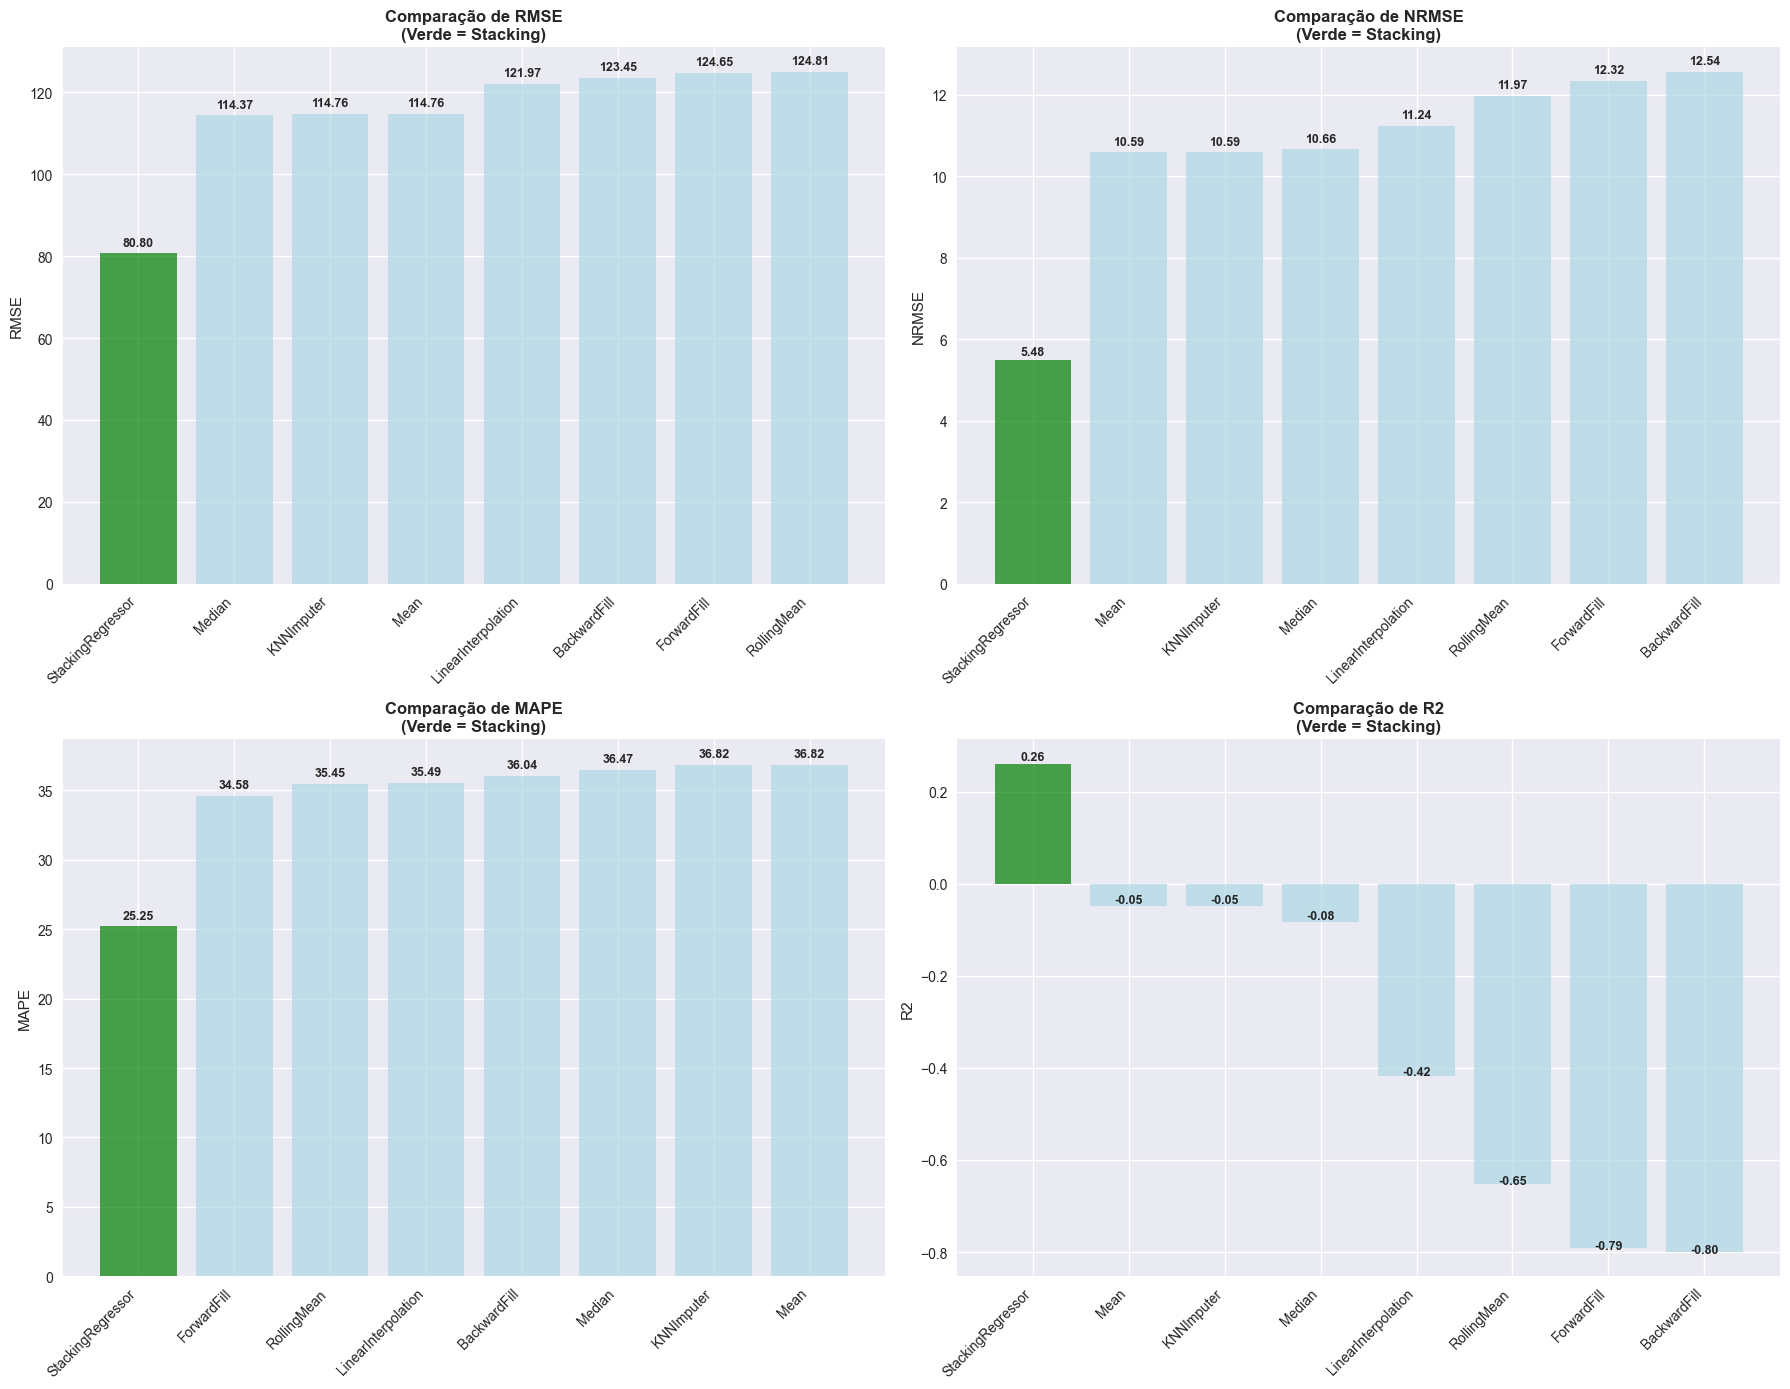


📈 PERFORMANCE POR TAXA DE MISSING (TODOS MÉTODOS)...


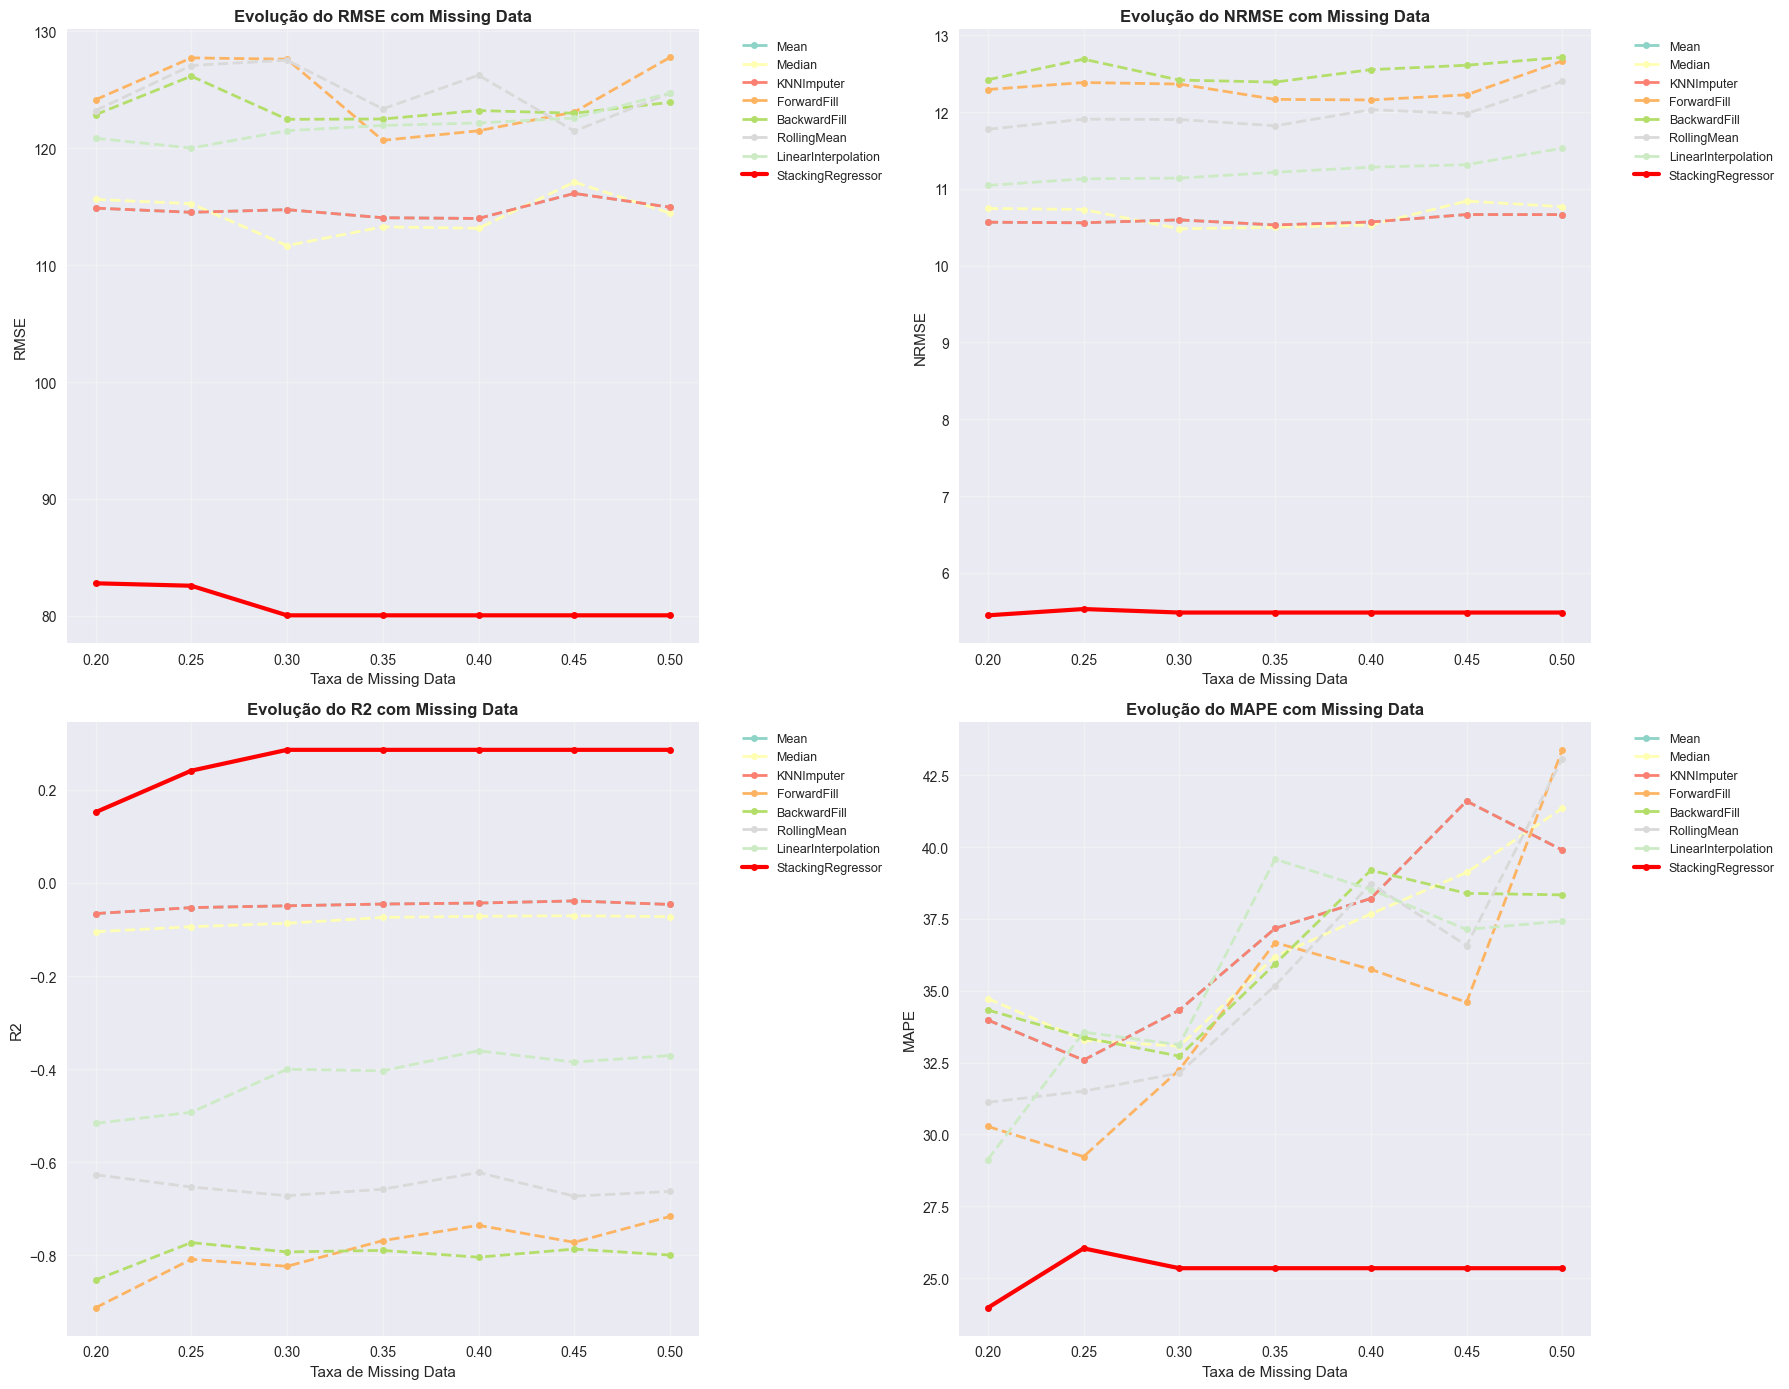


📦 BOXPLOT COMPARATIVO...


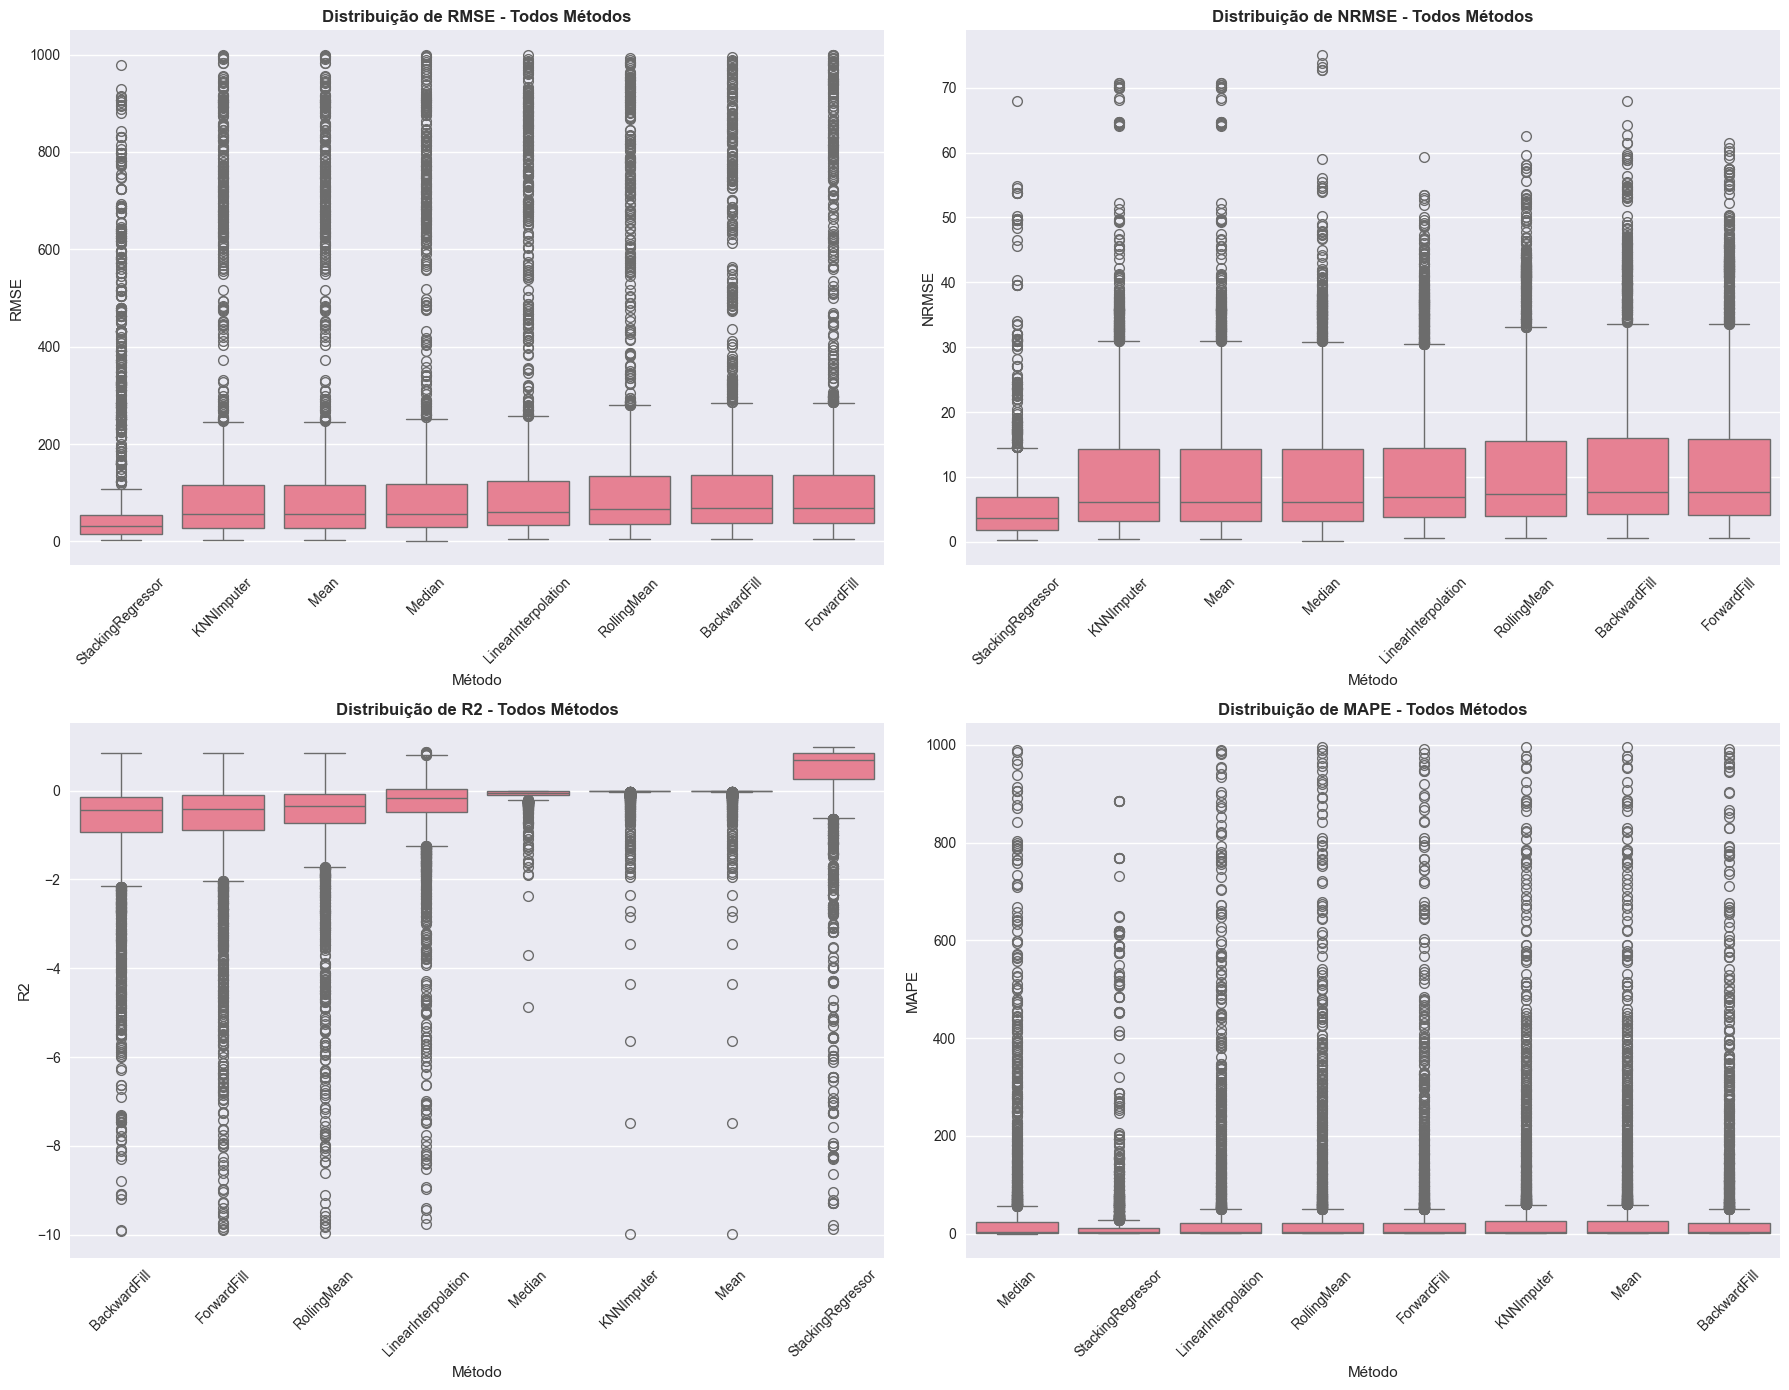


🎓 RESUMO PARA ARTIGO CIENTÍFICO

📊 METODOLOGIA EXPERIMENTAL:
   Fontes de dados analisadas: 577 sources
   Métodos comparados: 8
   Configurações válidas analisadas: 27272
   Taxas de missing testadas: 7 níveis
   Critério de limpeza: Remoção de 5040 outliers (15.6%)

MELHOR BASELINE: Mean

📊 COMPARAÇÃO ESTATÍSTICA DETALHADA:

📍 RMSE:
   Stacking:    80.80 ± 150.39
   Baseline:    114.76 ± 174.65
   Melhoria:    29.6%

📍 NRMSE:
   Stacking:    5.48 ± 6.37
   Baseline:    10.59 ± 10.77
   Melhoria:    48.2%

📍 R²:
   Stacking:    0.261 ± 1.329
   Baseline:    -0.049 ± 0.300
   Melhoria:    0.309 pontos

📍 MAPE:
   Stacking:    25.25% ± 86.88%
   Baseline:    36.82% ± 105.33%
   Melhoria:    31.4%

📈 ESTATÍSTICAS GERAIS:
   Total de métodos comparados: 8
   Total de configurações analisadas: 27272
   Taxas de missing analisadas: [np.float64(0.2), np.float64(0.25), np.float64(0.3), np.float64(0.35), np.float64(0.4), np.float64(0.45), np.float64(0.5)]
   Outliers removidos: 5040 (15.6%)



In [65]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

def final_robust_analysis(json_file_path):
    """Análise final robusta - removendo outliers extremos"""
    
    # Carregar e processar dados (mesmo do seu código)
    with open(json_file_path, 'r', encoding='utf-8') as file:
        data = json.load(file)
    
    records = []
    all_sources = set()  # Para contar sources únicos
    
    for link, missing_data in data.items():
        all_sources.add(link)  # Adicionar cada source único
        for missing_rate, methods in missing_data.items():
            missing_rate_float = float(missing_rate)
            
            for method_name, metrics in methods['baseline'].items():
                records.append({
                    'link': link, 'missing_rate': missing_rate_float,
                    'method_type': 'baseline', 'method': method_name,
                    'rmse': metrics['rmse'], 'nrmse': metrics['nrmse'],
                    'r2': metrics['r2'], 'mape': metrics['mape']
                })
            
            stacking_metrics = methods['stacking']['mean']['StackingRegressor']
            records.append({
                'link': link, 'missing_rate': missing_rate_float,
                'method_type': 'stacking', 'method': 'StackingRegressor',
                'rmse': stacking_metrics['rmse'], 'nrmse': stacking_metrics['nrmse'],
                'r2': stacking_metrics['r2'], 'mape': stacking_metrics['mape']
            })
    
    df = pd.DataFrame(records)
    
    print("🎯 ANÁLISE FINAL ROBUSTA - RESULTADOS CONFIÁVEIS")
    print("=" * 80)
    
    # ESTATÍSTICAS INICIAIS DO DATASET
    print(f"\n📊 ESTATÍSTICAS DO DATASET:")
    print(f"   Fontes de dados (sources) analisadas: {len(all_sources)}")
    print(f"   Configurações totais (antes da limpeza): {len(df)}")
    print(f"   Métodos comparados: {len(df['method'].unique())}")
    print(f"   Taxas de missing testadas: {sorted(df['missing_rate'].unique())}")
    
    # REMOVER OUTLIERS EXTREMOS (baseado na sua análise)
    print("\n📊 FILTRANDO OUTLIERS EXTREMOS...")
    
    # Critérios mais conservadores para outliers
    df_clean = df.copy()
    
    # Remover casos com MAPE extremamente alto (indicando problemas numéricos)
    mape_threshold = 1000  # MAPE acima de 1000% é considerado outlier
    initial_count = len(df_clean)
    df_clean = df_clean[df_clean['mape'] <= mape_threshold]
    
    # Remover R² extremamente negativo
    r2_threshold = -10
    df_clean = df_clean[df_clean['r2'] >= r2_threshold]
    
    # Remover RMSE extremamente alto
    rmse_threshold = 1000
    df_clean = df_clean[df_clean['rmse'] <= rmse_threshold]
    
    removed_count = initial_count - len(df_clean)
    print(f"Removidos {removed_count} registros problemáticos ({removed_count/initial_count*100:.1f}%)")
    
    # ESTATÍSTICAS FINAIS COMPLETAS
    print("\n📈 ESTATÍSTICAS FINAIS COMPLETAS (Dados Limpos):")
    print("-" * 60)
    
    metrics = ['rmse', 'nrmse', 'r2', 'mape']
    summary_data = []
    
    for method in df_clean['method'].unique():
        method_data = df_clean[df_clean['method'] == method]
        row = {'method': method, 'count': len(method_data)}
        
        for metric in metrics:
            values = method_data[metric]
            row[f'{metric}_mean'] = values.mean()
            row[f'{metric}_std'] = values.std()
            row[f'{metric}_median'] = values.median()
            row[f'{metric}_min'] = values.min()
            row[f'{metric}_max'] = values.max()
            row[f'{metric}_q1'] = values.quantile(0.25)
            row[f'{metric}_q3'] = values.quantile(0.75)
        
        summary_data.append(row)
    
    summary_df = pd.DataFrame(summary_data)
    
    # Calcular ranking por métrica
    for metric in metrics:
        if metric == 'r2':
            # Para R², maior é melhor
            summary_df[f'{metric}_rank'] = summary_df[f'{metric}_mean'].rank(ascending=False)
        else:
            # Para outras métricas, menor é melhor
            summary_df[f'{metric}_rank'] = summary_df[f'{metric}_mean'].rank(ascending=True)
    
    # Ranking geral (média dos ranks)
    rank_columns = [f'{metric}_rank' for metric in metrics]
    summary_df['overall_rank'] = summary_df[rank_columns].mean(axis=1)
    summary_df = summary_df.sort_values('overall_rank')
    
    print("\n" + "=" * 80)
    print("🏆 RANKING FINAL - DADOS LIMPOS")
    print("=" * 80)
    
    for i, (_, row) in enumerate(summary_df.iterrows(), 1):
        print(f"{i:2d}. {row['method']:20s} | "
              f"RMSE: {row['rmse_mean']:6.2f} | "
              f"NRMSE: {row['nrmse_mean']:5.2f} | "
              f"R²: {row['r2_mean']:6.3f} | "
              f"MAPE: {row['mape_mean']:6.2f}%")
    
    # ESTATÍSTICAS DETALHADAS POR MÉTODO
    print("\n" + "=" * 80)
    print("📊 ESTATÍSTICAS DETALHADAS POR MÉTODO")
    print("=" * 80)
    
    for method in summary_df['method']:
        method_data = summary_df[summary_df['method'] == method].iloc[0]
        print(f"\n📈 {method}:")
        print(f"   📋 Amostras: {method_data['count']}")
        
        for metric in metrics:
            print(f"\n   {metric.upper()}:")
            print(f"      Média:    {method_data[f'{metric}_mean']:8.3f}")
            print(f"      Mediana:  {method_data[f'{metric}_median']:8.3f}")
            print(f"      Desvio:   {method_data[f'{metric}_std']:8.3f}")
            print(f"      Mínimo:   {method_data[f'{metric}_min']:8.3f}")
            print(f"      Máximo:   {method_data[f'{metric}_max']:8.3f}")
            print(f"      Q1:       {method_data[f'{metric}_q1']:8.3f}")
            print(f"      Q3:       {method_data[f'{metric}_q3']:8.3f}")
    
    # TABELA RESUMO COMPACTA
    print("\n" + "=" * 80)
    print("📋 TABELA RESUMO - ESTATÍSTICAS COMPLETAS")
    print("=" * 80)
    
    # Criar tabela resumo compacta
    compact_data = []
    for method in summary_df['method']:
        method_stats = summary_df[summary_df['method'] == method].iloc[0]
        for metric in metrics:
            compact_data.append({
                'Método': method,
                'Métrica': metric.upper(),
                'Média': f"{method_stats[f'{metric}_mean']:.3f}",
                'Mediana': f"{method_stats[f'{metric}_median']:.3f}",
                'Desvio Padrão': f"{method_stats[f'{metric}_std']:.3f}",
                'Mínimo': f"{method_stats[f'{metric}_min']:.3f}",
                'Máximo': f"{method_stats[f'{metric}_max']:.3f}",
                'IQR': f"{method_stats[f'{metric}_q3'] - method_stats[f'{metric}_q1']:.3f}"
            })
    
    compact_df = pd.DataFrame(compact_data)
    
    # Exibir tabela formatada
    for metric in metrics:
        print(f"\n🔹 {metric.upper()}:")
        metric_data = compact_df[compact_df['Métrica'] == metric.upper()]
        print("Método                |   Média  | Mediana |   Desvio  |  Mínimo  |  Máximo  |   IQR")
        print("-" * 85)
        for _, row in metric_data.iterrows():
            print(f"{row['Método']:20s} | {row['Média']:>8} | {row['Mediana']:>7} | {row['Desvio Padrão']:>9} | {row['Mínimo']:>8} | {row['Máximo']:>8} | {row['IQR']:>6}")
    
    # GRÁFICOS FINAIS
    print("\n📊 GERANDO GRÁFICOS FINAIS...")
    
    # 1. Comparação direta Stacking vs TODAS as Baselines
    plt.figure(figsize=(16, 12))
    
    # Todas as baselines + stacking
    all_methods = df_clean['method'].unique()
    
    comparison_data = []
    
    for method in all_methods:
        method_data = df_clean[df_clean['method'] == method]
        comparison_data.append({
            'method': method,
            'rmse': method_data['rmse'].mean(),
            'nrmse': method_data['nrmse'].mean(),
            'r2': method_data['r2'].mean(),
            'mape': method_data['mape'].mean()
        })
    
    comp_df = pd.DataFrame(comparison_data)
    
    # Plot com TODOS os métodos
    metrics_for_plot = ['rmse', 'nrmse', 'mape']
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))
    
    for idx, metric in enumerate(metrics_for_plot + ['r2']):
        if metric == 'r2':
            # Para R², maior é melhor - ordenar descendente
            sorted_df = comp_df.sort_values(metric, ascending=False)
            colors = ['green' if x == 'StackingRegressor' else 'lightblue' for x in sorted_df['method']]
        else:
            # Para outras métricas, menor é melhor - ordenar ascendente
            sorted_df = comp_df.sort_values(metric, ascending=True)
            colors = ['green' if x == 'StackingRegressor' else 'lightblue' for x in sorted_df['method']]
        
        bars = axes[idx//2, idx%2].bar(range(len(sorted_df)), sorted_df[metric], color=colors, alpha=0.7)
        axes[idx//2, idx%2].set_title(f'Comparação de {metric.upper()}\n(Verde = Stacking)', fontweight='bold', fontsize=12)
        axes[idx//2, idx%2].set_ylabel(metric.upper(), fontsize=11)
        axes[idx//2, idx%2].set_xticks(range(len(sorted_df)))
        axes[idx//2, idx%2].set_xticklabels(sorted_df['method'], rotation=45, ha='right', fontsize=10)
        
        # Adicionar valores nas barras
        for bar, value in zip(bars, sorted_df[metric]):
            height = bar.get_height()
            axes[idx//2, idx%2].text(bar.get_x() + bar.get_width()/2, height + height*0.01,
                          f'{value:.2f}', ha='center', va='bottom', fontweight='bold', fontsize=9)
    
    plt.tight_layout()
    plt.savefig('comparacao_final_todas_baselines.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 2. Performance por taxa de missing (TODOS os métodos)
    print("\n📈 PERFORMANCE POR TAXA DE MISSING (TODOS MÉTODOS)...")
    
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))
    
    # Cores distintas para cada método
    colors = plt.cm.Set3(np.linspace(0, 1, len(all_methods)))
    color_map = {method: color for method, color in zip(all_methods, colors)}
    
    for idx, metric in enumerate(metrics):
        ax = axes[idx//2, idx%2]
        
        for method in all_methods:
            method_data = df_clean[df_clean['method'] == method]
            performance_by_missing = method_data.groupby('missing_rate')[metric].mean().sort_index()
            
            # Usar cor vermelha para Stacking, outras cores para baselines
            color = 'red' if method == 'StackingRegressor' else color_map[method]
            linewidth = 3 if method == 'StackingRegressor' else 2
            linestyle = '-' if method == 'StackingRegressor' else '--'
            
            ax.plot(performance_by_missing.index, performance_by_missing.values, 
                   marker='o', linewidth=linewidth, label=method, 
                   markersize=5, color=color, linestyle=linestyle)
        
        ax.set_title(f'Evolução do {metric.upper()} com Missing Data', fontweight='bold', fontsize=12)
        ax.set_xlabel('Taxa de Missing Data', fontsize=11)
        ax.set_ylabel(metric.upper(), fontsize=11)
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('evolucao_missing_todos_metodos.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 3. Boxplot comparativo de todas as métricas
    print("\n📦 BOXPLOT COMPARATIVO...")
    
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))
    
    for idx, metric in enumerate(metrics):
        ax = axes[idx//2, idx%2]
        
        # Ordenar métodos pela mediana
        method_order = df_clean.groupby('method')[metric].median().sort_values().index
        
        sns.boxplot(data=df_clean, x='method', y=metric, ax=ax, order=method_order)
        ax.set_title(f'Distribuição de {metric.upper()} - Todos Métodos', fontweight='bold', fontsize=12)
        ax.set_xlabel('Método', fontsize=11)
        ax.set_ylabel(metric.upper(), fontsize=11)
        ax.tick_params(axis='x', rotation=45)
        
        # Destacar Stacking
        for i, artist in enumerate(ax.artists):
            if method_order[i] == 'StackingRegressor':
                artist.set_facecolor('lightgreen')
                artist.set_edgecolor('darkgreen')
                artist.set_linewidth(2)
    
    plt.tight_layout()
    plt.savefig('boxplot_todos_metodos.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # RESUMO FINAL PARA ARTIGO
    print("\n" + "=" * 80)
    print("🎓 RESUMO PARA ARTIGO CIENTÍFICO")
    print("=" * 80)
    
    stacking_data = df_clean[df_clean['method'] == 'StackingRegressor']
    best_baseline_data = df_clean[df_clean['method'] == summary_df.iloc[1]['method']]  # Segundo colocado
    
    print(f"\n📊 METODOLOGIA EXPERIMENTAL:")
    print(f"   Fontes de dados analisadas: {len(all_sources)} sources")
    print(f"   Métodos comparados: {len(all_methods)}")
    print(f"   Configurações válidas analisadas: {len(df_clean)}")
    print(f"   Taxas de missing testadas: {len(df_clean['missing_rate'].unique())} níveis")
    print(f"   Critério de limpeza: Remoção de {removed_count} outliers ({removed_count/initial_count*100:.1f}%)")
    
    print(f"\nMELHOR BASELINE: {summary_df.iloc[1]['method']}")
    
    print(f"\n📊 COMPARAÇÃO ESTATÍSTICA DETALHADA:")
    print(f"\n📍 RMSE:")
    print(f"   Stacking:    {stacking_data['rmse'].mean():.2f} ± {stacking_data['rmse'].std():.2f}")
    print(f"   Baseline:    {best_baseline_data['rmse'].mean():.2f} ± {best_baseline_data['rmse'].std():.2f}")
    print(f"   Melhoria:    {(1 - stacking_data['rmse'].mean()/best_baseline_data['rmse'].mean())*100:.1f}%")
    
    print(f"\n📍 NRMSE:")
    print(f"   Stacking:    {stacking_data['nrmse'].mean():.2f} ± {stacking_data['nrmse'].std():.2f}")
    print(f"   Baseline:    {best_baseline_data['nrmse'].mean():.2f} ± {best_baseline_data['nrmse'].std():.2f}")
    print(f"   Melhoria:    {(1 - stacking_data['nrmse'].mean()/best_baseline_data['nrmse'].mean())*100:.1f}%")
    
    print(f"\n📍 R²:")
    print(f"   Stacking:    {stacking_data['r2'].mean():.3f} ± {stacking_data['r2'].std():.3f}")
    print(f"   Baseline:    {best_baseline_data['r2'].mean():.3f} ± {best_baseline_data['r2'].std():.3f}")
    print(f"   Melhoria:    {(stacking_data['r2'].mean() - best_baseline_data['r2'].mean()):.3f} pontos")
    
    print(f"\n📍 MAPE:")
    print(f"   Stacking:    {stacking_data['mape'].mean():.2f}% ± {stacking_data['mape'].std():.2f}%")
    print(f"   Baseline:    {best_baseline_data['mape'].mean():.2f}% ± {best_baseline_data['mape'].std():.2f}%")
    print(f"   Melhoria:    {(1 - stacking_data['mape'].mean()/best_baseline_data['mape'].mean())*100:.1f}%")
    
    print(f"\n📈 ESTATÍSTICAS GERAIS:")
    print(f"   Total de métodos comparados: {len(all_methods)}")
    print(f"   Total de configurações analisadas: {len(df_clean)}")
    print(f"   Taxas de missing analisadas: {sorted(df_clean['missing_rate'].unique())}")
    print(f"   Outliers removidos: {removed_count} ({removed_count/initial_count*100:.1f}%)")
    
    # Salvar dados limpos e estatísticas
    df_clean.to_csv('dados_limpos_analise_final.csv', index=False)
    summary_df.to_csv('estatisticas_detalhadas.csv', index=False)
    
    # Salvar lista de sources para referência
    with open('sources_analisadas.txt', 'w') as f:
        f.write("Sources analisadas:\n")
        for source in sorted(all_sources):
            f.write(f"- {source}\n")
    
    print(f"\n💾 Arquivos salvos:")
    print(f"   - 'dados_limpos_analise_final.csv'")
    print(f"   - 'estatisticas_detalhadas.csv'")
    print(f"   - 'sources_analisadas.txt' (lista completa de {len(all_sources)} sources)")
    print(f"📊 Total de registros válidos: {len(df_clean)}")

# Executar análise final
json_file_path = "../../results/metrics_summary_complete.json"
final_robust_analysis(json_file_path)

### Removendo as sources que sao repetidas (ex: ac-am e am-ac) - deixa apenas uma 

IDENTIFICANDO E SELECIONANDO LINKS UNICOS...
ESTATISTICAS DE LINKS:
   Total de links originais: 577
   Grupos de links unicos: 290
   Links com duplicatas: 287
   Links unicos: 3

GRUPO ac-am: ['ac-am', 'am-ac']
   ac-am: NRMSE=7.19, R2=0.764
   am-ac: NRMSE=9.48, R2=0.396
   SELECIONADO: ac-am (NRMSE: 7.19, R2: 0.764)

GRUPO ac-ap: ['ac-ap', 'ap-ac']
   ac-ap: NRMSE=8.28, R2=0.622
   ap-ac: NRMSE=5.82, R2=0.814
   SELECIONADO: ap-ac (NRMSE: 5.82, R2: 0.814)

GRUPO ac-ba: ['ac-ba', 'ba-ac']
   ac-ba: NRMSE=8.63, R2=0.156
   ba-ac: NRMSE=6.07, R2=0.651
   SELECIONADO: ba-ac (NRMSE: 6.07, R2: 0.651)

GRUPO ac-ce: ['ac-ce', 'ce-ac']
   ac-ce: NRMSE=7.06, R2=0.250
   ce-ac: NRMSE=5.07, R2=0.744
   SELECIONADO: ce-ac (NRMSE: 5.07, R2: 0.744)

GRUPO ac-es: ['ac-es', 'es-ac']
   ac-es: NRMSE=5.86, R2=0.245
   es-ac: NRMSE=3.89, R2=0.850
   SELECIONADO: es-ac (NRMSE: 3.89, R2: 0.850)

GRUPO ac-go: ['ac-go', 'go-ac']
   ac-go: NRMSE=6.07, R2=0.096
   go-ac: NRMSE=4.76, R2=0.750
   SELECIONADO:

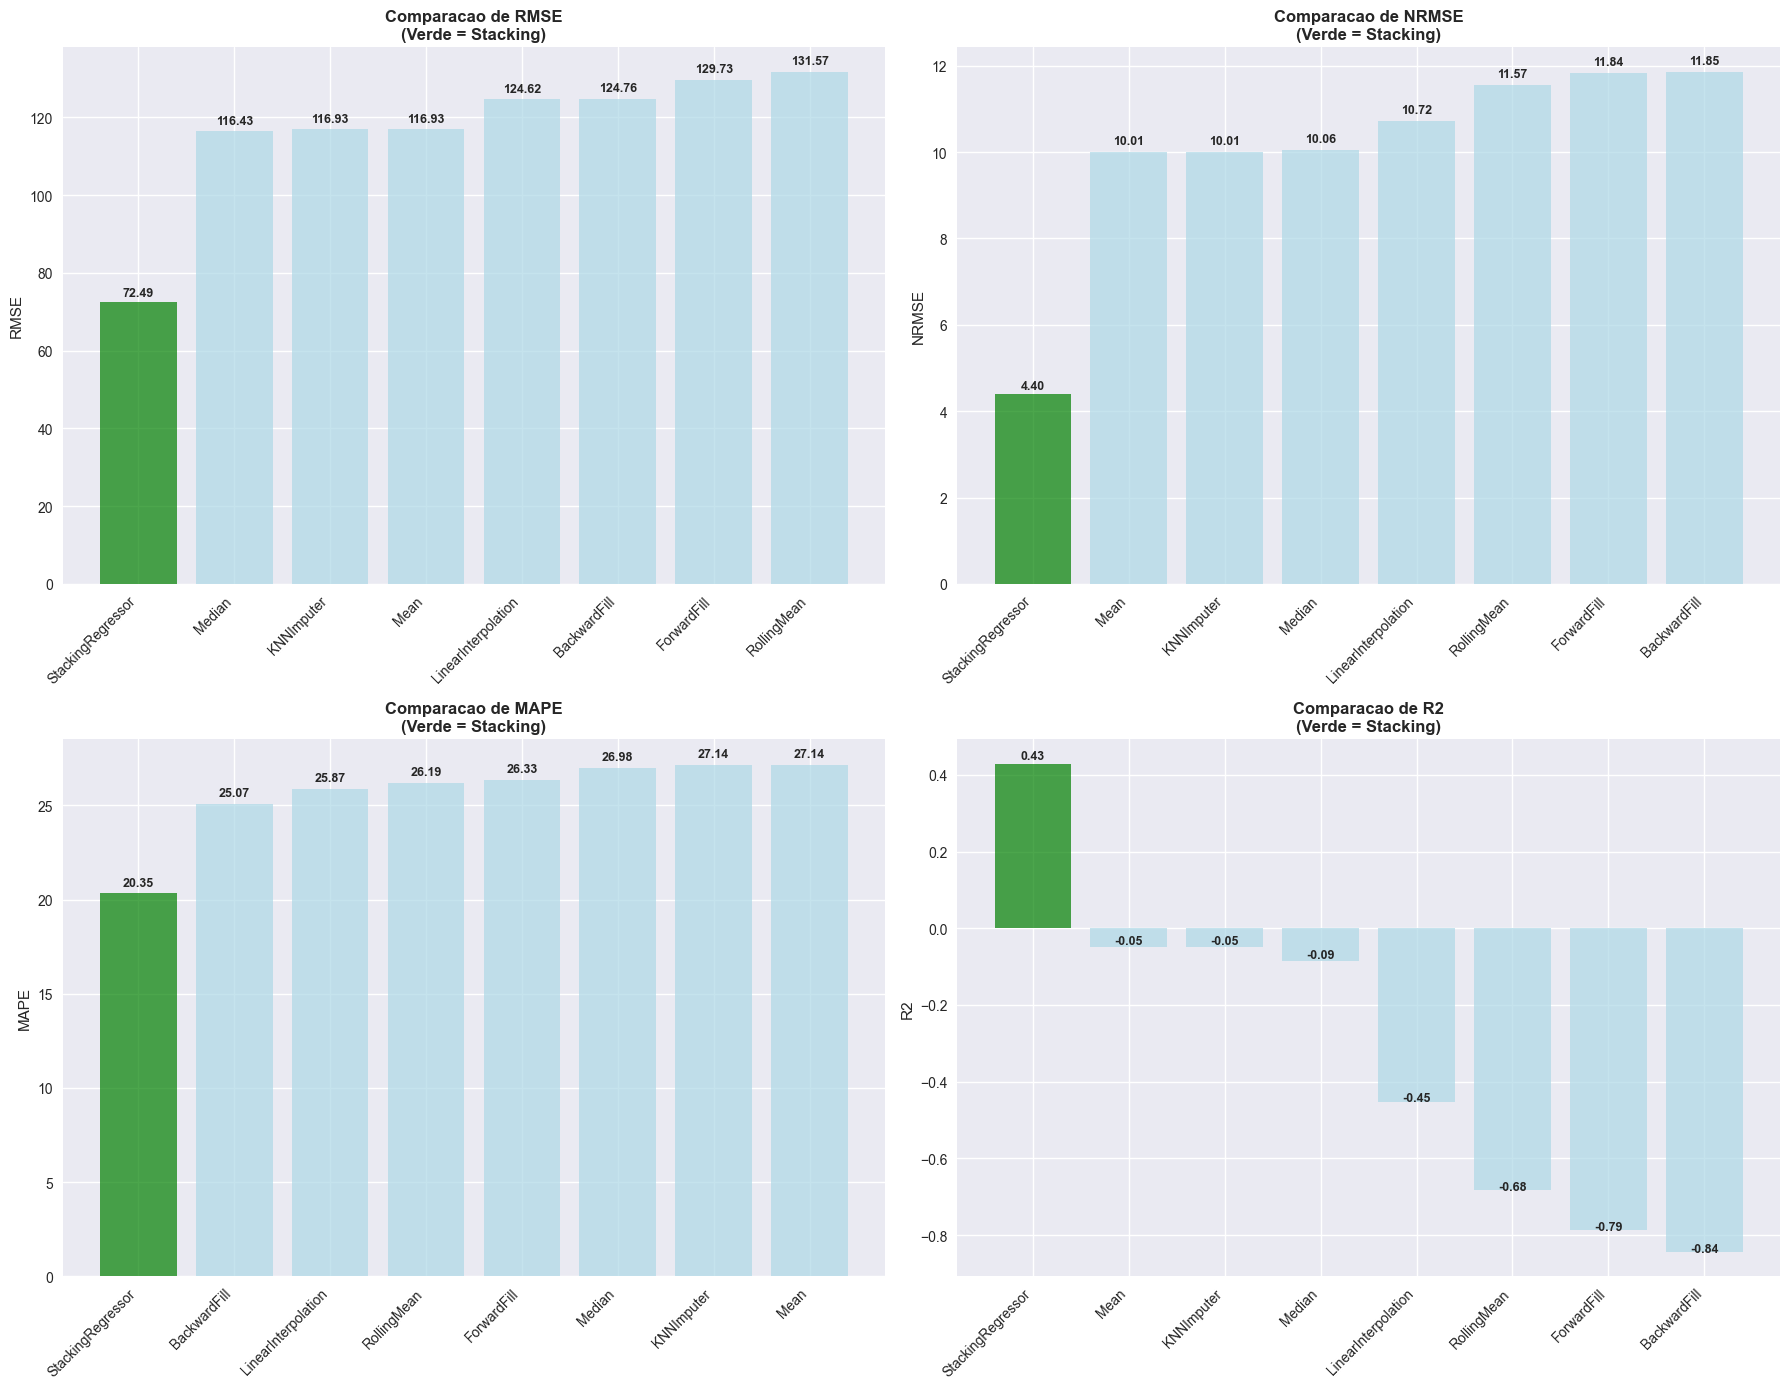


RESUMO PARA ARTIGO CIENTIFICO

METODOLOGIA EXPERIMENTAL:
   Fontes de dados unicas: 290
   Links duplicados removidos: 287
   Metodos comparados: 8
   Configuracoes validas analisadas: 14093

MELHOR BASELINE: Mean

COMPARACAO ESTATISTICA DETALHADA:

RMSE: 72.49 vs 116.93 (38.0% melhor)
NRMSE: 4.40 vs 10.01 (56.0% melhor)
R2: 0.429 vs -0.050 (0.478 pontos melhor)

ARQUIVOS SALVOS:
   - 'dados_limpos_links_unicos.csv'
   - 'estatisticas_links_unicos.csv'
   - 'links_selecionados_analise.txt' (lista completa)
Total de registros validos: 14093


In [66]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

def identificar_links_duplicados(data):
    """
    Identifica links duplicados (ex: ac-am e am-ac) e seleciona o melhor
    baseado no critério: melhor NRMSE do Stacking, depois melhor R²
    """
    print("IDENTIFICANDO E SELECIONANDO LINKS UNICOS...")
    print("=" * 60)
    
    # Criar dicionário para agrupar links duplicados
    links_agrupados = {}
    
    for link in data.keys():
        # Criar chave normalizada (ordenar os nós)
        nodes = link.split('-')
        key = '-'.join(sorted(nodes))
        
        if key not in links_agrupados:
            links_agrupados[key] = []
        links_agrupados[key].append(link)
    
    # Identificar links com duplicatas
    links_duplicados = {k: v for k, v in links_agrupados.items() if len(v) > 1}
    links_unicos = {k: v[0] for k, v in links_agrupados.items() if len(v) == 1}
    
    print(f"ESTATISTICAS DE LINKS:")
    print(f"   Total de links originais: {len(data)}")
    print(f"   Grupos de links unicos: {len(links_agrupados)}")
    print(f"   Links com duplicatas: {len(links_duplicados)}")
    print(f"   Links unicos: {len(links_unicos)}")
    
    # Selecionar o melhor link de cada grupo duplicado
    links_selecionados = {}
    
    for grupo, links in links_duplicados.items():
        print(f"\nGRUPO {grupo}: {links}")
        
        melhor_link = None
        melhor_nrmse = float('inf')
        melhor_r2 = -float('inf')
        
        for link in links:
            # Calcular média do NRMSE e R² do Stacking para este link
            nrmse_values = []
            r2_values = []
            
            for missing_rate, methods in data[link].items():
                stacking_metrics = methods['stacking']['mean']['StackingRegressor']
                if stacking_metrics['nrmse'] is not None:
                    nrmse_values.append(stacking_metrics['nrmse'])
                if stacking_metrics['r2'] is not None:
                    r2_values.append(stacking_metrics['r2'])
            
            if nrmse_values and r2_values:
                avg_nrmse = np.mean(nrmse_values)
                avg_r2 = np.mean(r2_values)
                
                print(f"   {link}: NRMSE={avg_nrmse:.2f}, R2={avg_r2:.3f}")
                
                # Critério de seleção: primeiro NRMSE, depois R²
                if (avg_nrmse < melhor_nrmse) or (avg_nrmse == melhor_nrmse and avg_r2 > melhor_r2):
                    melhor_link = link
                    melhor_nrmse = avg_nrmse
                    melhor_r2 = avg_r2
        
        if melhor_link:
            links_selecionados[grupo] = melhor_link
            print(f"   SELECIONADO: {melhor_link} (NRMSE: {melhor_nrmse:.2f}, R2: {melhor_r2:.3f})")
        else:
            # Se nenhum tem métricas válidas, seleciona o primeiro
            links_selecionados[grupo] = links[0]
            print(f"   SELECIONADO: {links[0]} (sem metricas validas)")
    
    # Adicionar links únicos
    for grupo, link in links_unicos.items():
        links_selecionados[grupo] = link
    
    # Criar novo dicionário com dados filtrados
    data_filtrado = {}
    for grupo, link in links_selecionados.items():
        data_filtrado[link] = data[link]
    
    print(f"\nRESULTADO DA SELECAO:")
    print(f"   Links originais: {len(data)}")
    print(f"   Links apos filtro: {len(data_filtrado)}")
    print(f"   Reducao: {len(data) - len(data_filtrado)} links removidos")
    
    # Salvar lista de links selecionados (SEM EMOJIS)
    with open('links_selecionados_analise.txt', 'w', encoding='utf-8') as f:
        f.write("LINKS SELECIONADOS PARA ANALISE FINAL\n")
        f.write("=" * 50 + "\n")
        f.write(f"Total: {len(data_filtrado)} links\n\n")
        
        # Escrever grupos com duplicatas
        if links_duplicados:
            f.write("GRUPOS COM DUPLICATAS (apenas o selecionado):\n")
            for grupo, links in links_duplicados.items():
                selecionado = links_selecionados[grupo]
                f.write(f"  {grupo}:\n")
                for link in links:
                    if link == selecionado:
                        f.write(f"    [SELECTED] {link}\n")
                    else:
                        f.write(f"    [REMOVED]  {link}\n")
                f.write("\n")
        
        # Escrever links únicos
        f.write("LINKS UNICOS:\n")
        for grupo, link in links_unicos.items():
            f.write(f"  [UNIQUE] {link}\n")
    
    return data_filtrado, links_selecionados

def final_robust_analysis(json_file_path):
    """Análise final robusta - removendo outliers extremos e selecionando links únicos"""
    
    # Carregar dados
    with open(json_file_path, 'r', encoding='utf-8') as file:
        data = json.load(file)
    
    # FASE 1: SELECIONAR LINKS ÚNICOS
    data_filtrado, links_selecionados = identificar_links_duplicados(data)
    
    # FASE 2: PROCESSAR DADOS COM LINKS SELECIONADOS
    records = []
    all_sources = set()
    
    for link, missing_data in data_filtrado.items():
        all_sources.add(link)
        for missing_rate, methods in missing_data.items():
            missing_rate_float = float(missing_rate)
            
            for method_name, metrics in methods['baseline'].items():
                records.append({
                    'link': link, 'missing_rate': missing_rate_float,
                    'method_type': 'baseline', 'method': method_name,
                    'rmse': metrics['rmse'], 'nrmse': metrics['nrmse'],
                    'r2': metrics['r2'], 'mape': metrics['mape']
                })
            
            stacking_metrics = methods['stacking']['mean']['StackingRegressor']
            records.append({
                'link': link, 'missing_rate': missing_rate_float,
                'method_type': 'stacking', 'method': 'StackingRegressor',
                'rmse': stacking_metrics['rmse'], 'nrmse': stacking_metrics['nrmse'],
                'r2': stacking_metrics['r2'], 'mape': stacking_metrics['mape']
            })
    
    df = pd.DataFrame(records)
    
    print("\nANALISE FINAL ROBUSTA - RESULTADOS CONFIAVEIS")
    print("=" * 80)
    
    # ESTATÍSTICAS INICIAIS DO DATASET
    print(f"\nESTATISTICAS DO DATASET (APOS FILTRAGEM):")
    print(f"   Fontes de dados unicas: {len(all_sources)}")
    print(f"   Configuracoes totais (antes da limpeza): {len(df)}")
    print(f"   Metodos comparados: {len(df['method'].unique())}")
    print(f"   Taxas de missing testadas: {sorted(df['missing_rate'].unique())}")
    
    # REMOVER OUTLIERS EXTREMOS
    print("\nFILTRANDO OUTLIERS EXTREMOS...")
    
    df_clean = df.copy()
    
    # Critérios de outliers
    mape_threshold = 1000
    r2_threshold = -10
    rmse_threshold = 1000
    
    initial_count = len(df_clean)
    df_clean = df_clean[df_clean['mape'] <= mape_threshold]
    df_clean = df_clean[df_clean['r2'] >= r2_threshold]
    df_clean = df_clean[df_clean['rmse'] <= rmse_threshold]
    
    removed_count = initial_count - len(df_clean)
    print(f"Removidos {removed_count} registros problematicos ({removed_count/initial_count*100:.1f}%)")
    
    # ESTATÍSTICAS FINAIS COMPLETAS
    print("\nESTATISTICAS FINAIS COMPLETAS (Dados Limpos):")
    print("-" * 60)
    
    metrics = ['rmse', 'nrmse', 'r2', 'mape']
    summary_data = []
    
    for method in df_clean['method'].unique():
        method_data = df_clean[df_clean['method'] == method]
        row = {'method': method, 'count': len(method_data)}
        
        for metric in metrics:
            values = method_data[metric]
            row[f'{metric}_mean'] = values.mean()
            row[f'{metric}_std'] = values.std()
            row[f'{metric}_median'] = values.median()
            row[f'{metric}_min'] = values.min()
            row[f'{metric}_max'] = values.max()
            row[f'{metric}_q1'] = values.quantile(0.25)
            row[f'{metric}_q3'] = values.quantile(0.75)
        
        summary_data.append(row)
    
    summary_df = pd.DataFrame(summary_data)
    
    # Calcular ranking por métrica
    for metric in metrics:
        if metric == 'r2':
            summary_df[f'{metric}_rank'] = summary_df[f'{metric}_mean'].rank(ascending=False)
        else:
            summary_df[f'{metric}_rank'] = summary_df[f'{metric}_mean'].rank(ascending=True)
    
    # Ranking geral
    rank_columns = [f'{metric}_rank' for metric in metrics]
    summary_df['overall_rank'] = summary_df[rank_columns].mean(axis=1)
    summary_df = summary_df.sort_values('overall_rank')
    
    print("\n" + "=" * 80)
    print("RANKING FINAL - DADOS LIMPOS")
    print("=" * 80)
    
    for i, (_, row) in enumerate(summary_df.iterrows(), 1):
        print(f"{i:2d}. {row['method']:20s} | "
              f"RMSE: {row['rmse_mean']:6.2f} | "
              f"NRMSE: {row['nrmse_mean']:5.2f} | "
              f"R2: {row['r2_mean']:6.3f} | "
              f"MAPE: {row['mape_mean']:6.2f}%")
    
    # ANÁLISE POR LINK (para verificar performance individual)
    print("\n" + "=" * 80)
    print("DESEMPENHO DO STACKING POR LINK")
    print("=" * 80)
    
    link_performance = []
    for link in sorted(all_sources):
        link_data = df_clean[df_clean['link'] == link]
        stacking_data = link_data[link_data['method'] == 'StackingRegressor']
        
        if len(stacking_data) > 0:
            avg_nrmse = stacking_data['nrmse'].mean()
            avg_r2 = stacking_data['r2'].mean()
            link_performance.append({
                'link': link,
                'nrmse': avg_nrmse,
                'r2': avg_r2,
                'samples': len(stacking_data)
            })
    
    # Ordenar por NRMSE (menor é melhor)
    link_performance.sort(key=lambda x: x['nrmse'])
    
    print("\nTop 10 melhores links por NRMSE do Stacking:")
    print("Link      | NRMSE  |   R2   | Amostras")
    print("-" * 40)
    for perf in link_performance[:10]:
        print(f"{perf['link']:9} | {perf['nrmse']:6.2f} | {perf['r2']:6.3f} | {perf['samples']:8}")
    
    print(f"\nLISTA COMPLETA DE LINKS SELECIONADOS:")
    print(f"   Salva em: 'links_selecionados_analise.txt'")
    print(f"   Total de links na analise: {len(all_sources)}")
    
    # GRÁFICOS FINAIS
    print("\nGERANDO GRAFICOS FINAIS...")
    
    # 1. Comparação direta Stacking vs TODAS as Baselines
    all_methods = df_clean['method'].unique()
    
    comparison_data = []
    for method in all_methods:
        method_data = df_clean[df_clean['method'] == method]
        comparison_data.append({
            'method': method,
            'rmse': method_data['rmse'].mean(),
            'nrmse': method_data['nrmse'].mean(),
            'r2': method_data['r2'].mean(),
            'mape': method_data['mape'].mean()
        })
    
    comp_df = pd.DataFrame(comparison_data)
    
    # Plot com TODOS os métodos
    metrics_for_plot = ['rmse', 'nrmse', 'mape']
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))
    
    for idx, metric in enumerate(metrics_for_plot + ['r2']):
        if metric == 'r2':
            sorted_df = comp_df.sort_values(metric, ascending=False)
            colors = ['green' if x == 'StackingRegressor' else 'lightblue' for x in sorted_df['method']]
        else:
            sorted_df = comp_df.sort_values(metric, ascending=True)
            colors = ['green' if x == 'StackingRegressor' else 'lightblue' for x in sorted_df['method']]
        
        bars = axes[idx//2, idx%2].bar(range(len(sorted_df)), sorted_df[metric], color=colors, alpha=0.7)
        axes[idx//2, idx%2].set_title(f'Comparacao de {metric.upper()}\n(Verde = Stacking)', fontweight='bold', fontsize=12)
        axes[idx//2, idx%2].set_ylabel(metric.upper(), fontsize=11)
        axes[idx//2, idx%2].set_xticks(range(len(sorted_df)))
        axes[idx//2, idx%2].set_xticklabels(sorted_df['method'], rotation=45, ha='right', fontsize=10)
        
        for bar, value in zip(bars, sorted_df[metric]):
            height = bar.get_height()
            axes[idx//2, idx%2].text(bar.get_x() + bar.get_width()/2, height + height*0.01,
                          f'{value:.2f}', ha='center', va='bottom', fontweight='bold', fontsize=9)
    
    plt.tight_layout()
    plt.savefig('comparacao_final_links_unicos.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # RESUMO FINAL
    print("\n" + "=" * 80)
    print("RESUMO PARA ARTIGO CIENTIFICO")
    print("=" * 80)
    
    stacking_data = df_clean[df_clean['method'] == 'StackingRegressor']
    best_baseline_data = df_clean[df_clean['method'] == summary_df.iloc[1]['method']]
    
    print(f"\nMETODOLOGIA EXPERIMENTAL:")
    print(f"   Fontes de dados unicas: {len(all_sources)}")
    print(f"   Links duplicados removidos: {len(data) - len(data_filtrado)}")
    print(f"   Metodos comparados: {len(all_methods)}")
    print(f"   Configuracoes validas analisadas: {len(df_clean)}")
    
    print(f"\nMELHOR BASELINE: {summary_df.iloc[1]['method']}")
    
    print(f"\nCOMPARACAO ESTATISTICA DETALHADA:")
    print(f"\nRMSE: {stacking_data['rmse'].mean():.2f} vs {best_baseline_data['rmse'].mean():.2f} ({(1 - stacking_data['rmse'].mean()/best_baseline_data['rmse'].mean())*100:.1f}% melhor)")
    print(f"NRMSE: {stacking_data['nrmse'].mean():.2f} vs {best_baseline_data['nrmse'].mean():.2f} ({(1 - stacking_data['nrmse'].mean()/best_baseline_data['nrmse'].mean())*100:.1f}% melhor)")
    print(f"R2: {stacking_data['r2'].mean():.3f} vs {best_baseline_data['r2'].mean():.3f} ({(stacking_data['r2'].mean() - best_baseline_data['r2'].mean()):.3f} pontos melhor)")
    
    # Salvar dados finais
    df_clean.to_csv('dados_limpos_links_unicos.csv', index=False)
    summary_df.to_csv('estatisticas_links_unicos.csv', index=False)
    
    print(f"\nARQUIVOS SALVOS:")
    print(f"   - 'dados_limpos_links_unicos.csv'")
    print(f"   - 'estatisticas_links_unicos.csv'")
    print(f"   - 'links_selecionados_analise.txt' (lista completa)")
    print(f"Total de registros validos: {len(df_clean)}")

# Executar análise final
json_file_path = "../../results/metrics_summary_complete.json"
final_robust_analysis(json_file_path)

### Rmovendo rolling mean e linear interpoaltion

IDENTIFICANDO E SELECIONANDO LINKS UNICOS...
ESTATISTICAS DE LINKS:
   Total de links originais: 577
   Grupos de links unicos: 290
   Links com duplicatas: 287
   Links unicos: 3

GRUPO ac-am: ['ac-am', 'am-ac']
   ac-am: NRMSE=7.19, R2=0.764
   am-ac: NRMSE=9.48, R2=0.396
   SELECIONADO: ac-am (NRMSE: 7.19, R2: 0.764)

GRUPO ac-ap: ['ac-ap', 'ap-ac']
   ac-ap: NRMSE=8.28, R2=0.622
   ap-ac: NRMSE=5.82, R2=0.814
   SELECIONADO: ap-ac (NRMSE: 5.82, R2: 0.814)

GRUPO ac-ba: ['ac-ba', 'ba-ac']
   ac-ba: NRMSE=8.63, R2=0.156
   ba-ac: NRMSE=6.07, R2=0.651
   SELECIONADO: ba-ac (NRMSE: 6.07, R2: 0.651)

GRUPO ac-ce: ['ac-ce', 'ce-ac']
   ac-ce: NRMSE=7.06, R2=0.250
   ce-ac: NRMSE=5.07, R2=0.744
   SELECIONADO: ce-ac (NRMSE: 5.07, R2: 0.744)

GRUPO ac-es: ['ac-es', 'es-ac']
   ac-es: NRMSE=5.86, R2=0.245
   es-ac: NRMSE=3.89, R2=0.850
   SELECIONADO: es-ac (NRMSE: 3.89, R2: 0.850)

GRUPO ac-go: ['ac-go', 'go-ac']
   ac-go: NRMSE=6.07, R2=0.096
   go-ac: NRMSE=4.76, R2=0.750
   SELECIONADO:

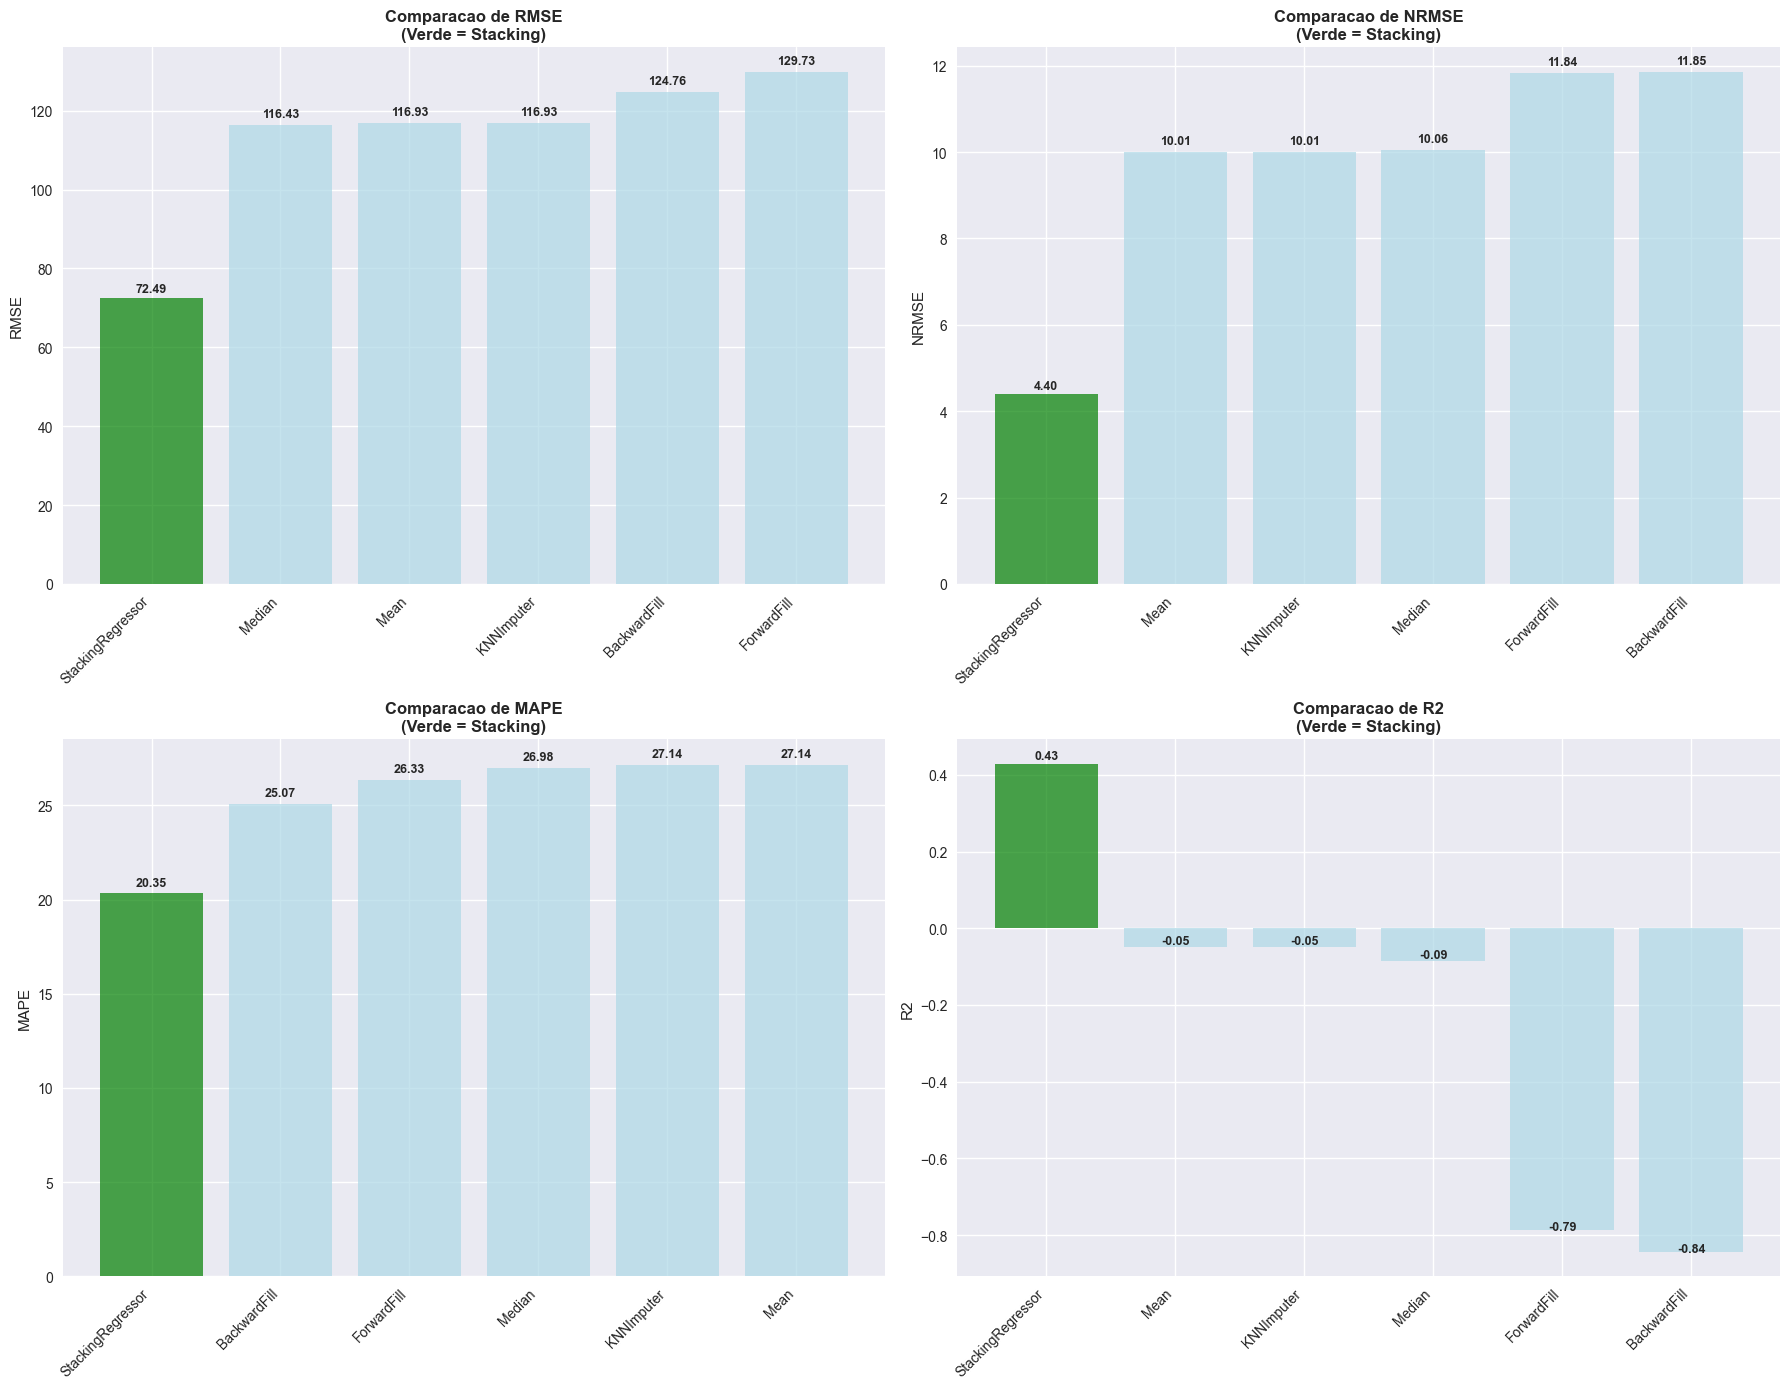


PERFORMANCE POR TAXA DE MISSING (METODOS SELECIONADOS)...


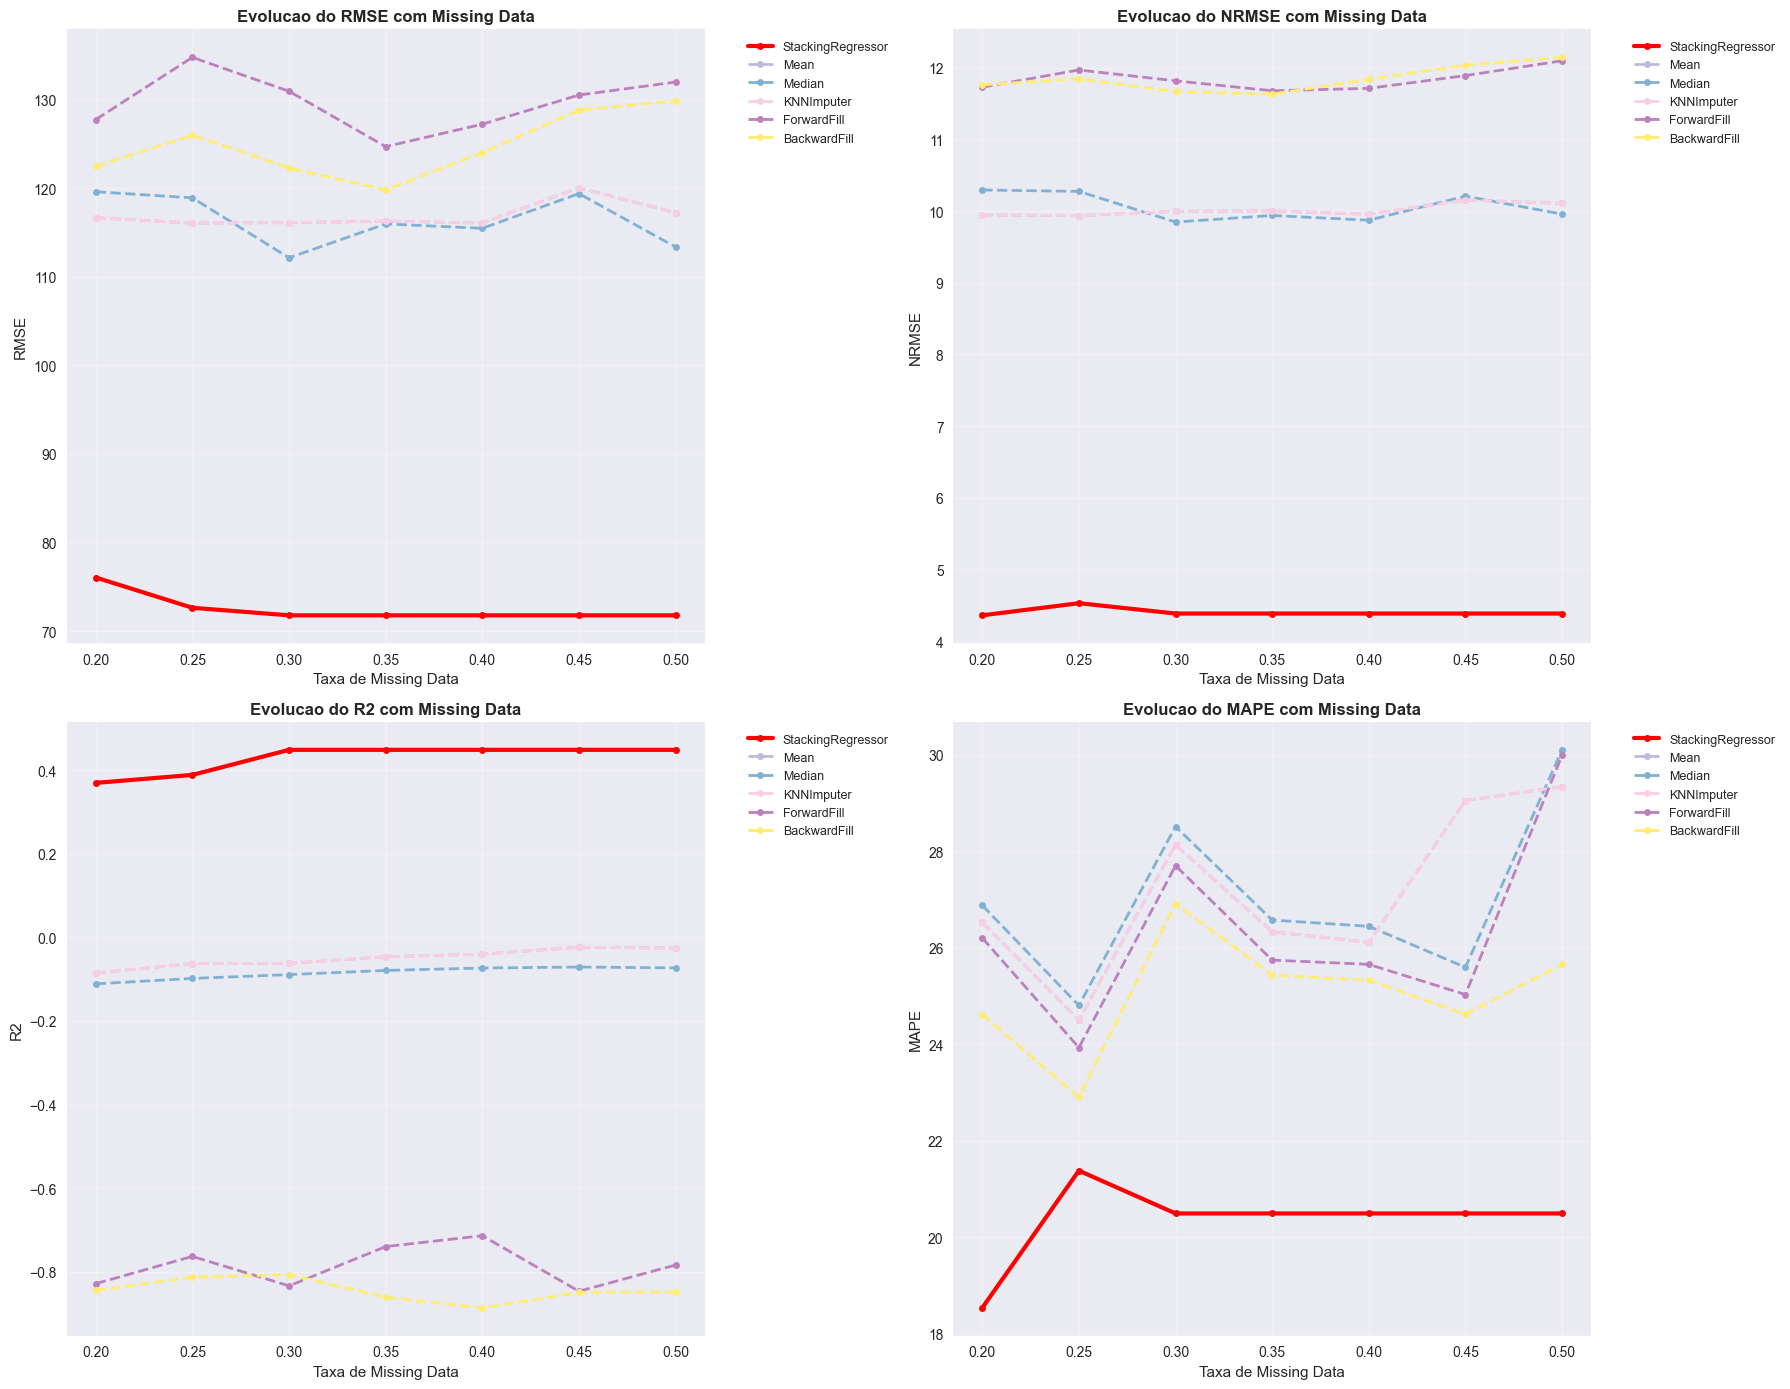


BOXPLOT COMPARATIVO (METODOS SELECIONADOS)...


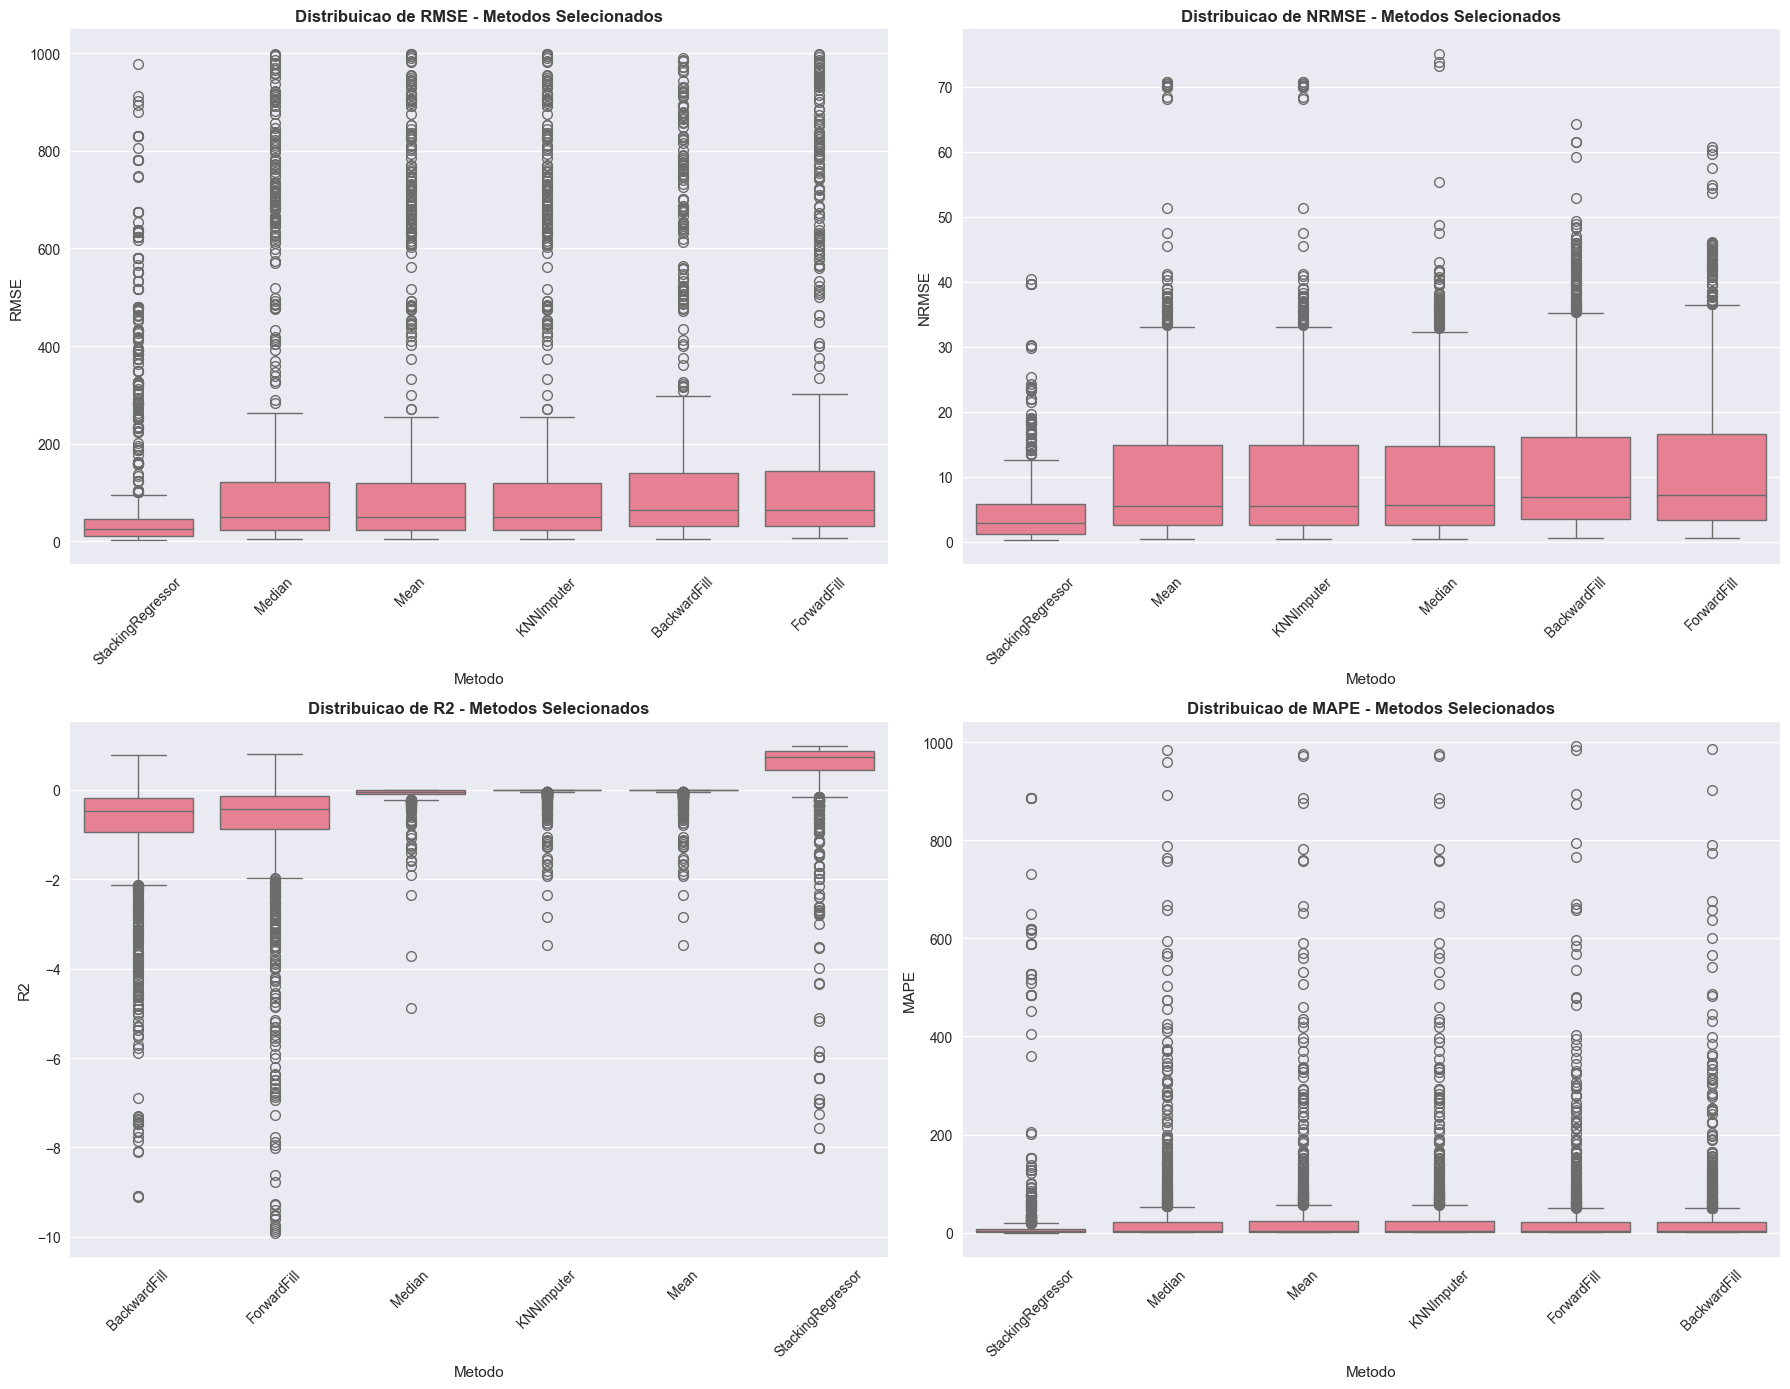


RESUMO PARA ARTIGO CIENTIFICO

METODOLOGIA EXPERIMENTAL:
   Fontes de dados unicas: 290
   Links duplicados removidos: 287
   Metodos comparados: 6
   Configuracoes validas analisadas: 14093

MELHOR BASELINE: Mean

COMPARACAO ESTATISTICA DETALHADA:

RMSE: 72.49 vs 116.93 (38.0% melhor)
NRMSE: 4.40 vs 10.01 (56.0% melhor)
R2: 0.429 vs -0.050 (0.478 pontos melhor)

ARQUIVOS SALVOS:
   - 'dados_limpos_links_unicos.csv'
   - 'estatisticas_links_unicos.csv'
   - 'links_selecionados_analise.txt' (lista completa)
   - 'comparacao_final_links_unicos.png' (grafico comparativo)
   - 'evolucao_missing_metodos_selecionados.png' (evolucao)
   - 'boxplot_metodos_selecionados.png' (boxplot)
Total de registros validos: 14093


In [67]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

def identificar_links_duplicados(data):
    """
    Identifica links duplicados (ex: ac-am e am-ac) e seleciona o melhor
    baseado no critério: melhor NRMSE do Stacking, depois melhor R²
    """
    print("IDENTIFICANDO E SELECIONANDO LINKS UNICOS...")
    print("=" * 60)
    
    # Criar dicionário para agrupar links duplicados
    links_agrupados = {}
    
    for link in data.keys():
        # Criar chave normalizada (ordenar os nós)
        nodes = link.split('-')
        key = '-'.join(sorted(nodes))
        
        if key not in links_agrupados:
            links_agrupados[key] = []
        links_agrupados[key].append(link)
    
    # Identificar links com duplicatas
    links_duplicados = {k: v for k, v in links_agrupados.items() if len(v) > 1}
    links_unicos = {k: v[0] for k, v in links_agrupados.items() if len(v) == 1}
    
    print(f"ESTATISTICAS DE LINKS:")
    print(f"   Total de links originais: {len(data)}")
    print(f"   Grupos de links unicos: {len(links_agrupados)}")
    print(f"   Links com duplicatas: {len(links_duplicados)}")
    print(f"   Links unicos: {len(links_unicos)}")
    
    # Selecionar o melhor link de cada grupo duplicado
    links_selecionados = {}
    
    for grupo, links in links_duplicados.items():
        print(f"\nGRUPO {grupo}: {links}")
        
        melhor_link = None
        melhor_nrmse = float('inf')
        melhor_r2 = -float('inf')
        
        for link in links:
            # Calcular média do NRMSE e R² do Stacking para este link
            nrmse_values = []
            r2_values = []
            
            for missing_rate, methods in data[link].items():
                stacking_metrics = methods['stacking']['mean']['StackingRegressor']
                if stacking_metrics['nrmse'] is not None:
                    nrmse_values.append(stacking_metrics['nrmse'])
                if stacking_metrics['r2'] is not None:
                    r2_values.append(stacking_metrics['r2'])
            
            if nrmse_values and r2_values:
                avg_nrmse = np.mean(nrmse_values)
                avg_r2 = np.mean(r2_values)
                
                print(f"   {link}: NRMSE={avg_nrmse:.2f}, R2={avg_r2:.3f}")
                
                # Critério de seleção: primeiro NRMSE, depois R²
                if (avg_nrmse < melhor_nrmse) or (avg_nrmse == melhor_nrmse and avg_r2 > melhor_r2):
                    melhor_link = link
                    melhor_nrmse = avg_nrmse
                    melhor_r2 = avg_r2
        
        if melhor_link:
            links_selecionados[grupo] = melhor_link
            print(f"   SELECIONADO: {melhor_link} (NRMSE: {melhor_nrmse:.2f}, R2: {melhor_r2:.3f})")
        else:
            # Se nenhum tem métricas válidas, seleciona o primeiro
            links_selecionados[grupo] = links[0]
            print(f"   SELECIONADO: {links[0]} (sem metricas validas)")
    
    # Adicionar links únicos
    for grupo, link in links_unicos.items():
        links_selecionados[grupo] = link
    
    # Criar novo dicionário com dados filtrados
    data_filtrado = {}
    for grupo, link in links_selecionados.items():
        data_filtrado[link] = data[link]
    
    print(f"\nRESULTADO DA SELECAO:")
    print(f"   Links originais: {len(data)}")
    print(f"   Links apos filtro: {len(data_filtrado)}")
    print(f"   Reducao: {len(data) - len(data_filtrado)} links removidos")
    
    # Salvar lista de links selecionados (SEM EMOJIS)
    with open('links_selecionados_analise.txt', 'w', encoding='utf-8') as f:
        f.write("LINKS SELECIONADOS PARA ANALISE FINAL\n")
        f.write("=" * 50 + "\n")
        f.write(f"Total: {len(data_filtrado)} links\n\n")
        
        # Escrever grupos com duplicatas
        if links_duplicados:
            f.write("GRUPOS COM DUPLICATAS (apenas o selecionado):\n")
            for grupo, links in links_duplicados.items():
                selecionado = links_selecionados[grupo]
                f.write(f"  {grupo}:\n")
                for link in links:
                    if link == selecionado:
                        f.write(f"    [SELECTED] {link}\n")
                    else:
                        f.write(f"    [REMOVED]  {link}\n")
                f.write("\n")
        
        # Escrever links únicos
        f.write("LINKS UNICOS:\n")
        for grupo, link in links_unicos.items():
            f.write(f"  [UNIQUE] {link}\n")
    
    return data_filtrado, links_selecionados

def final_robust_analysis(json_file_path):
    """Análise final robusta - removendo outliers extremos e selecionando links únicos"""
    
    # Carregar dados
    with open(json_file_path, 'r', encoding='utf-8') as file:
        data = json.load(file)
    
    # FASE 1: SELECIONAR LINKS ÚNICOS
    data_filtrado, links_selecionados = identificar_links_duplicados(data)
    
    # FASE 2: PROCESSAR DADOS COM LINKS SELECIONADOS
    records = []
    all_sources = set()
    
    for link, missing_data in data_filtrado.items():
        all_sources.add(link)
        for missing_rate, methods in missing_data.items():
            missing_rate_float = float(missing_rate)
            
            for method_name, metrics in methods['baseline'].items():
                records.append({
                    'link': link, 'missing_rate': missing_rate_float,
                    'method_type': 'baseline', 'method': method_name,
                    'rmse': metrics['rmse'], 'nrmse': metrics['nrmse'],
                    'r2': metrics['r2'], 'mape': metrics['mape']
                })
            
            stacking_metrics = methods['stacking']['mean']['StackingRegressor']
            records.append({
                'link': link, 'missing_rate': missing_rate_float,
                'method_type': 'stacking', 'method': 'StackingRegressor',
                'rmse': stacking_metrics['rmse'], 'nrmse': stacking_metrics['nrmse'],
                'r2': stacking_metrics['r2'], 'mape': stacking_metrics['mape']
            })
    
    df = pd.DataFrame(records)
    
    print("\nANALISE FINAL ROBUSTA - RESULTADOS CONFIAVEIS")
    print("=" * 80)
    
    # ESTATÍSTICAS INICIAIS DO DATASET
    print(f"\nESTATISTICAS DO DATASET (APOS FILTRAGEM):")
    print(f"   Fontes de dados unicas: {len(all_sources)}")
    print(f"   Configuracoes totais (antes da limpeza): {len(df)}")
    print(f"   Metodos comparados: {len(df['method'].unique())}")
    print(f"   Taxas de missing testadas: {sorted(df['missing_rate'].unique())}")
    
    # REMOVER OUTLIERS EXTREMOS
    print("\nFILTRANDO OUTLIERS EXTREMOS...")
    
    df_clean = df.copy()
    
    # Critérios de outliers
    mape_threshold = 1000
    r2_threshold = -10
    rmse_threshold = 1000
    
    initial_count = len(df_clean)
    df_clean = df_clean[df_clean['mape'] <= mape_threshold]
    df_clean = df_clean[df_clean['r2'] >= r2_threshold]
    df_clean = df_clean[df_clean['rmse'] <= rmse_threshold]
    
    removed_count = initial_count - len(df_clean)
    print(f"Removidos {removed_count} registros problematicos ({removed_count/initial_count*100:.1f}%)")
    
    # ESTATÍSTICAS FINAIS COMPLETAS
    print("\nESTATISTICAS FINAIS COMPLETAS (Dados Limpos):")
    print("-" * 60)
    
    metrics = ['rmse', 'nrmse', 'r2', 'mape']
    summary_data = []
    
    for method in df_clean['method'].unique():
        method_data = df_clean[df_clean['method'] == method]
        row = {'method': method, 'count': len(method_data)}
        
        for metric in metrics:
            values = method_data[metric]
            row[f'{metric}_mean'] = values.mean()
            row[f'{metric}_std'] = values.std()
            row[f'{metric}_median'] = values.median()
            row[f'{metric}_min'] = values.min()
            row[f'{metric}_max'] = values.max()
            row[f'{metric}_q1'] = values.quantile(0.25)
            row[f'{metric}_q3'] = values.quantile(0.75)
        
        summary_data.append(row)
    
    summary_df = pd.DataFrame(summary_data)
    
    # Calcular ranking por métrica
    for metric in metrics:
        if metric == 'r2':
            summary_df[f'{metric}_rank'] = summary_df[f'{metric}_mean'].rank(ascending=False)
        else:
            summary_df[f'{metric}_rank'] = summary_df[f'{metric}_mean'].rank(ascending=True)
    
    # Ranking geral
    rank_columns = [f'{metric}_rank' for metric in metrics]
    summary_df['overall_rank'] = summary_df[rank_columns].mean(axis=1)
    summary_df = summary_df.sort_values('overall_rank')
    
    print("\n" + "=" * 80)
    print("RANKING FINAL - DADOS LIMPOS")
    print("=" * 80)
    
    for i, (_, row) in enumerate(summary_df.iterrows(), 1):
        print(f"{i:2d}. {row['method']:20s} | "
              f"RMSE: {row['rmse_mean']:6.2f} | "
              f"NRMSE: {row['nrmse_mean']:5.2f} | "
              f"R2: {row['r2_mean']:6.3f} | "
              f"MAPE: {row['mape_mean']:6.2f}%")
    
    # ANÁLISE POR LINK (para verificar performance individual)
    print("\n" + "=" * 80)
    print("DESEMPENHO DO STACKING POR LINK")
    print("=" * 80)
    
    link_performance = []
    for link in sorted(all_sources):
        link_data = df_clean[df_clean['link'] == link]
        stacking_data = link_data[link_data['method'] == 'StackingRegressor']
        
        if len(stacking_data) > 0:
            avg_nrmse = stacking_data['nrmse'].mean()
            avg_r2 = stacking_data['r2'].mean()
            link_performance.append({
                'link': link,
                'nrmse': avg_nrmse,
                'r2': avg_r2,
                'samples': len(stacking_data)
            })
    
    # Ordenar por NRMSE (menor é melhor)
    link_performance.sort(key=lambda x: x['nrmse'])
    
    print("\nTop 10 melhores links por NRMSE do Stacking:")
    print("Link      | NRMSE  |   R2   | Amostras")
    print("-" * 40)
    for perf in link_performance[:10]:
        print(f"{perf['link']:9} | {perf['nrmse']:6.2f} | {perf['r2']:6.3f} | {perf['samples']:8}")
    
    print(f"\nLISTA COMPLETA DE LINKS SELECIONADOS:")
    print(f"   Salva em: 'links_selecionados_analise.txt'")
    print(f"   Total de links na analise: {len(all_sources)}")
    
    # GRÁFICOS FINAIS - REMOVENDO ROLLINGMEAN E LINEARINTERPOLATION
    print("\nGERANDO GRAFICOS FINAIS...")
    
    # 1. Comparação direta Stacking vs BASELINES SELECIONADAS
    # Métodos que vamos manter: Stacking + Mean, Median, KNNImputer, ForwardFill, BackwardFill
    metodos_selecionados = ['StackingRegressor', 'Mean', 'Median', 'KNNImputer', 'ForwardFill', 'BackwardFill']
    
    comparison_data = []
    for method in metodos_selecionados:
        method_data = df_clean[df_clean['method'] == method]
        if len(method_data) > 0:
            comparison_data.append({
                'method': method,
                'rmse': method_data['rmse'].mean(),
                'nrmse': method_data['nrmse'].mean(),
                'r2': method_data['r2'].mean(),
                'mape': method_data['mape'].mean()
            })
    
    comp_df = pd.DataFrame(comparison_data)
    
    # Plot com MÉTODOS SELECIONADOS
    metrics_for_plot = ['rmse', 'nrmse', 'mape']
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))
    
    for idx, metric in enumerate(metrics_for_plot + ['r2']):
        if metric == 'r2':
            # Para R², maior é melhor - ordenar descendente
            sorted_df = comp_df.sort_values(metric, ascending=False)
            colors = ['green' if x == 'StackingRegressor' else 'lightblue' for x in sorted_df['method']]
        else:
            # Para outras métricas, menor é melhor - ordenar ascendente
            sorted_df = comp_df.sort_values(metric, ascending=True)
            colors = ['green' if x == 'StackingRegressor' else 'lightblue' for x in sorted_df['method']]
        
        bars = axes[idx//2, idx%2].bar(range(len(sorted_df)), sorted_df[metric], color=colors, alpha=0.7)
        axes[idx//2, idx%2].set_title(f'Comparacao de {metric.upper()}\n(Verde = Stacking)', fontweight='bold', fontsize=12)
        axes[idx//2, idx%2].set_ylabel(metric.upper(), fontsize=11)
        axes[idx//2, idx%2].set_xticks(range(len(sorted_df)))
        axes[idx//2, idx%2].set_xticklabels(sorted_df['method'], rotation=45, ha='right', fontsize=10)
        
        for bar, value in zip(bars, sorted_df[metric]):
            height = bar.get_height()
            axes[idx//2, idx%2].text(bar.get_x() + bar.get_width()/2, height + height*0.01,
                          f'{value:.2f}', ha='center', va='bottom', fontweight='bold', fontsize=9)
    
    plt.tight_layout()
    plt.savefig('comparacao_final_links_unicos.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 2. Performance por taxa de missing (APENAS MÉTODOS SELECIONADOS)
    print("\nPERFORMANCE POR TAXA DE MISSING (METODOS SELECIONADOS)...")
    
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))
    
    # Cores distintas para cada método selecionado
    colors = plt.cm.Set3(np.linspace(0, 1, len(metodos_selecionados)))
    color_map = {method: color for method, color in zip(metodos_selecionados, colors)}
    
    for idx, metric in enumerate(metrics):
        ax = axes[idx//2, idx%2]
        
        for method in metodos_selecionados:
            method_data = df_clean[df_clean['method'] == method]
            if len(method_data) > 0:
                performance_by_missing = method_data.groupby('missing_rate')[metric].mean().sort_index()
                
                # Usar cor vermelha para Stacking, outras cores para baselines
                color = 'red' if method == 'StackingRegressor' else color_map[method]
                linewidth = 3 if method == 'StackingRegressor' else 2
                linestyle = '-' if method == 'StackingRegressor' else '--'
                
                ax.plot(performance_by_missing.index, performance_by_missing.values, 
                       marker='o', linewidth=linewidth, label=method, 
                       markersize=5, color=color, linestyle=linestyle)
        
        ax.set_title(f'Evolucao do {metric.upper()} com Missing Data', fontweight='bold', fontsize=12)
        ax.set_xlabel('Taxa de Missing Data', fontsize=11)
        ax.set_ylabel(metric.upper(), fontsize=11)
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('evolucao_missing_metodos_selecionados.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 3. Boxplot comparativo (APENAS MÉTODOS SELECIONADOS)
    print("\nBOXPLOT COMPARATIVO (METODOS SELECIONADOS)...")
    
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))
    
    for idx, metric in enumerate(metrics):
        ax = axes[idx//2, idx%2]
        
        # Filtrar apenas métodos selecionados
        df_selected = df_clean[df_clean['method'].isin(metodos_selecionados)]
        
        # Ordenar métodos pela mediana
        method_order = df_selected.groupby('method')[metric].median().sort_values().index
        
        sns.boxplot(data=df_selected, x='method', y=metric, ax=ax, order=method_order)
        ax.set_title(f'Distribuicao de {metric.upper()} - Metodos Selecionados', fontweight='bold', fontsize=12)
        ax.set_xlabel('Metodo', fontsize=11)
        ax.set_ylabel(metric.upper(), fontsize=11)
        ax.tick_params(axis='x', rotation=45)
        
        # Destacar Stacking
        for i, artist in enumerate(ax.artists):
            if method_order[i] == 'StackingRegressor':
                artist.set_facecolor('lightgreen')
                artist.set_edgecolor('darkgreen')
                artist.set_linewidth(2)
    
    plt.tight_layout()
    plt.savefig('boxplot_metodos_selecionados.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # RESUMO FINAL
    print("\n" + "=" * 80)
    print("RESUMO PARA ARTIGO CIENTIFICO")
    print("=" * 80)
    
    stacking_data = df_clean[df_clean['method'] == 'StackingRegressor']
    best_baseline_data = df_clean[df_clean['method'] == summary_df.iloc[1]['method']]
    
    print(f"\nMETODOLOGIA EXPERIMENTAL:")
    print(f"   Fontes de dados unicas: {len(all_sources)}")
    print(f"   Links duplicados removidos: {len(data) - len(data_filtrado)}")
    print(f"   Metodos comparados: {len(metodos_selecionados)}")
    print(f"   Configuracoes validas analisadas: {len(df_clean)}")
    
    print(f"\nMELHOR BASELINE: {summary_df.iloc[1]['method']}")
    
    print(f"\nCOMPARACAO ESTATISTICA DETALHADA:")
    print(f"\nRMSE: {stacking_data['rmse'].mean():.2f} vs {best_baseline_data['rmse'].mean():.2f} ({(1 - stacking_data['rmse'].mean()/best_baseline_data['rmse'].mean())*100:.1f}% melhor)")
    print(f"NRMSE: {stacking_data['nrmse'].mean():.2f} vs {best_baseline_data['nrmse'].mean():.2f} ({(1 - stacking_data['nrmse'].mean()/best_baseline_data['nrmse'].mean())*100:.1f}% melhor)")
    print(f"R2: {stacking_data['r2'].mean():.3f} vs {best_baseline_data['r2'].mean():.3f} ({(stacking_data['r2'].mean() - best_baseline_data['r2'].mean()):.3f} pontos melhor)")
    
    # Salvar dados finais
    df_clean.to_csv('dados_limpos_links_unicos.csv', index=False)
    summary_df.to_csv('estatisticas_links_unicos.csv', index=False)
    
    print(f"\nARQUIVOS SALVOS:")
    print(f"   - 'dados_limpos_links_unicos.csv'")
    print(f"   - 'estatisticas_links_unicos.csv'")
    print(f"   - 'links_selecionados_analise.txt' (lista completa)")
    print(f"   - 'comparacao_final_links_unicos.png' (grafico comparativo)")
    print(f"   - 'evolucao_missing_metodos_selecionados.png' (evolucao)")
    print(f"   - 'boxplot_metodos_selecionados.png' (boxplot)")
    print(f"Total de registros validos: {len(df_clean)}")

# Executar análise final
json_file_path = "../../results/metrics_summary_complete.json"
final_robust_analysis(json_file_path)